<a href="https://colab.research.google.com/github/Witcape/AI_Practice/blob/main/ITERATION_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TEST

In [ ]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.7 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-zh72s4w3
  Entered build tracker: /tmp/pip-build-tracker-zh72s4w3
  Created temporary directory: /tmp/pip-install-ln3fqvc9
  Created temporary directory: /tmp/pip-ephem-wheel-cache-xgw71njy
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  Starting new HTTPS connection (1

In [ ]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [ ]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt

In [ ]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

In [ ]:
# GPU
lcpp_llm = None
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

In [ ]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

In [ ]:
CostFunction = sphere  #
nVar = 10  # Number of Decision Variables
VarSize = (nVar,)  # Size of Decision Variables Matrix
VarMin = -10  # Lower Bound of Variables
VarMax = 10  # Upper Bound of Variables

In [ ]:
MaxIt = 20  # Maximum Number of Iterations
nPop = 20

In [ ]:
w = 1  # Inertia Weight
wdamp = 0.99  # Inertia Weight Damping Ratio
c1 = 1.5  # Personal Learning Coefficient
c2 = 2.0  # Global Learning Coefficient

In [ ]:
VelMax = 0.1 * (VarMax - VarMin)
VelMin = -VelMax

In [ ]:
particles = []

for _ in range(nPop):
    position = np.random.uniform(VarMin, VarMax, VarSize)
    velocity = np.zeros(VarSize)
    cost = CostFunction(position)
    best_position = position.copy()
    best_cost = cost
    particles.append({
        'Position': position,
        'Velocity': velocity,
        'Cost': cost,
        'Best': {
            'Position': best_position,
            'Cost': best_cost
        }
    })
print(np.size(particles))

In [ ]:
GlobalBest = {'Position': None, 'Cost': np.inf}

for p in particles:
    if p['Cost'] < GlobalBest['Cost']:
        GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

BestCost = np.zeros(MaxIt)

In [ ]:
w_values = []
g_values = []

for it in range(MaxIt):
    for p in particles:
        # Update Velocity
        r1 = np.random.rand(*VarSize)
        r2 = np.random.rand(*VarSize)
        p['Velocity'] = (
            w * p['Velocity']
            + c1 * r1 * (p['Best']['Position'] - p['Position'])
            + c2 * r2 * (GlobalBest['Position'] - p['Position'])
        )

        # Apply Velocity Limits
        p['Velocity'] = np.maximum(p['Velocity'], VelMin)
        p['Velocity'] = np.minimum(p['Velocity'], VelMax)

        # Update Position
        p['Position'] += p['Velocity']

        # Velocity Mirror Effect
        IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
        p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

        # Apply Position Limits
        p['Position'] = np.maximum(p['Position'], VarMin)
        p['Position'] = np.minimum(p['Position'], VarMax)

        # Evaluation
        p['Cost'] = CostFunction(p['Position'])

        # Update Personal Best
        if p['Cost'] < p['Best']['Cost']:
            p['Best']['Position'] = p['Position'].copy()
            p['Best']['Cost'] = p['Cost']

            # Update Global Best
            if p['Best']['Cost'] < GlobalBest['Cost']:  # tell best cost using roullete wheel. LLM will check for global best
                GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']} # tell best cost using roullete wheel

    BestCost[it] = GlobalBest['Cost']

    print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

    prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
    w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

    USER: {prompt}

    ASSISTANT:
    '''

    w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                          repeat_penalty=1.2, top_k=150,
                          echo=True)

    g_values.append(GlobalBest['Cost'])
    BestCost[it] = GlobalBest['Cost']

    text_response = w_response['choices'][0]['text']
    value = re.findall(r'-?\d+\.\d+', text_response)
    value = [float(num) for num in value]

    value = value[np.size(value) - 1]
    print(f'w{it+1} = {value}')
    w_values.append(w)
    w = value

w_values.append(w)
print(w_values)

# Function

In [1]:
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.1.78 numpy==1.23.4 --force-reinstall --upgrade --no-cache-dir --verbose
!pip install huggingface_hub
!pip install llama-cpp-python==0.1.78
!pip install numpy==1.23.4

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.1 MB/s eta 0:00:00
  Running command pip subprocess to install build dependencies
  Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Non-user install by explicit request
  Created build tracker: /tmp/pip-build-tracker-u44z56gx
  Entered build tracker: /tmp/pip-build-tracker-u44z56gx
  Created temporary directory: /tmp/pip-install-ft_87p_d
  Created temporary directory: /tmp/pip-ephem-wheel-cache-ebcegc6s
  1 location(s) to search for versions of setuptools:
  * https://pypi.org/simple/setuptools/
  Fetching project page and analyzing links: https://pypi.org/simple/setuptools/
  Getting page https://pypi.org/simple/setuptools/
  Found index url https://pypi.org/simple/
  Looking up "https://pypi.org/simple/setuptools/" in the cache
  Request header has "max_age" as 0, cache bypassed
  No cache entry available
  Start

In [2]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGML"
model_basename = "llama-2-13b-chat.ggmlv3.q5_1.bin"

In [3]:
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import matplotlib.pyplot as plt
import time

In [4]:
model_path = hf_hub_download(repo_id=model_name_or_path, filename=model_basename)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


llama-2-13b-chat.ggmlv3.q5_1.bin:   0%|          | 0.00/9.76G [00:00<?, ?B/s]

In [5]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2, # CPU cores
    n_batch=512, # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    n_gpu_layers=32 # Change this value based on your model and your GPU VRAM pool.
    )

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | VSX = 0 | 


In [6]:
!pip install pyswarms
import numpy as np
import pyswarms as ps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 6.2 MB/s eta 0:00:00


In [7]:
import numpy as np
import re

def run_pso(
    CostFunction, nVar=10, VarMin=-10, VarMax=10, MaxIt=20, nPop=500,
    w=1, wdamp=0.99, c1=2.05, c2=2.05, n_threads=2, n_batch=512, n_gpu_layers=32, chi=0.729843788
):
    VarSize = (nVar,)
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax

    particles = []

    for _ in range(nPop):
        position = np.random.uniform(VarMin, VarMax, VarSize)
        velocity = np.zeros(VarSize)
        cost = CostFunction(position)
        best_position = position.copy()
        best_cost = cost
        particles.append({
            'Position': position,
            'Velocity': velocity,
            'Cost': cost,
            'Best': {
                'Position': best_position,
                'Cost': best_cost
            }
        })

    GlobalBest = {'Position': None, 'Cost': np.inf}

    for p in particles:
        if p['Cost'] < GlobalBest['Cost']:
            GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}

    BestCost = np.zeros(MaxIt)
    w_values = []
    g_values = []

    for it in range(MaxIt):
        for p in particles:
            r1 = np.random.rand(*VarSize)
            r2 = np.random.rand(*VarSize)
            p['Velocity'] = chi * (
                p['Velocity']
                + c1 * r1 * (p['Best']['Position'] - p['Position'])
                + c2 * r2 * (GlobalBest['Position'] - p['Position'])
            )

            # Apply Velocity Limits
            p['Velocity'] = np.maximum(p['Velocity'], VelMin)
            p['Velocity'] = np.minimum(p['Velocity'], VelMax)

            # Update Position
            p['Position'] += p['Velocity']

            # Velocity Mirror Effect
            IsOutside = (p['Position'] < VarMin) | (p['Position'] > VarMax)
            p['Velocity'][IsOutside] = -p['Velocity'][IsOutside]

            # Apply Position Limits
            p['Position'] = np.maximum(p['Position'], VarMin)
            p['Position'] = np.minimum(p['Position'], VarMax)

            # Evaluation
            p['Cost'] = CostFunction(p['Position'])

            # Update Personal Best
            if p['Cost'] < p['Best']['Cost']:
                p['Best']['Position'] = p['Position'].copy()
                p['Best']['Cost'] = p['Cost']

                # Update Global Best
                if p['Best']['Cost'] < GlobalBest['Cost']:
                    GlobalBest = {'Position': p['Best']['Position'].copy(), 'Cost': p['Best']['Cost']}


        BestCost[it] = GlobalBest['Cost']
        print(f"Iteration {it+1}: Best Cost = {BestCost[it]}")

        if(it <= 20):
          prompt = f"Generate a positive number a little lower than {w} and greater then 0.1 using Normalised Glorot Initialization. Don't write anything else, just write that number in decimal notation normally."
          w_finder_template = f'''SYSTEM: You are a helpful, respectful, and honest assistant. Always answer as helpfully.

          USER: {prompt}

          ASSISTANT:
          '''

          w_response = lcpp_llm(prompt=w_finder_template, max_tokens=256, temperature=0.5, top_p=0.95,
                                repeat_penalty=1.2, top_k=150, echo=True)

          text_response = w_response['choices'][0]['text']
          value = re.findall(r'-?\d+\.\d+', text_response)
          value = [float(num) for num in value]

          if value:
              w = value[-1]
              print(f"w{it+1} = {w}")
          else:
              print("Warning: LLM failed to provide a valid weight. Retaining previous weight.")

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

        else:
          w *= wdamp

          w_values.append(w)
          g_values.append(GlobalBest['Cost'])

    w_values.append(w)
    print("Final Weights:", w_values)
    return BestCost, w_values, g_values

In [8]:
# def sphere(x):
#     return sum(x**2)

In [9]:
# BestCost, w_values, g_values = run_pso(CostFunction=sphere)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os

# GNBG class definition
class GNBG:
    def __init__(self, MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition):
        self.MaxEvals = MaxEvals
        self.AcceptanceThreshold = AcceptanceThreshold
        self.Dimension = Dimension
        self.CompNum = CompNum
        self.MinCoordinate = MinCoordinate
        self.MaxCoordinate = MaxCoordinate
        self.CompMinPos = CompMinPos
        self.CompSigma = CompSigma
        self.CompH = CompH
        self.Mu = Mu
        self.Omega = Omega
        self.Lambda = Lambda
        self.RotationMatrix = RotationMatrix
        self.OptimumValue = OptimumValue
        self.OptimumPosition = OptimumPosition
        self.FEhistory = []
        self.FE = 0
        self.BestFoundPosition = None
        self.AcceptanceReachPoint = np.inf
        self.BestFoundResult = np.inf


    def fitness(self, X):
        if len(X.shape)<2:
            X = X.reshape(1,-1)
        SolutionNumber = X.shape[0]
        result = np.nan * np.ones(SolutionNumber)
        for jj in range(SolutionNumber):
            x = X[jj, :].reshape(-1, 1)  # Ensure column vector
            f = np.nan * np.ones(self.CompNum)
            for k in range(self.CompNum):
                if len(self.RotationMatrix.shape) == 3:
                    rotation_matrix = self.RotationMatrix[:, :, k]
                else:
                    rotation_matrix = self.RotationMatrix

                a = self.transform((x - self.CompMinPos[k, :].reshape(-1, 1)).T @ rotation_matrix.T, self.Mu[k, :], self.Omega[k, :])
                b = self.transform(rotation_matrix @ (x - self.CompMinPos[k, :].reshape(-1, 1)), self.Mu[k, :], self.Omega[k, :])
                f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]

            result[jj] = np.min(f)
            if self.FE > (self.MaxEvals-1):
                return result
            self.FE += 1
            self.FEhistory = np.append(self.FEhistory, result[jj])
            if self.BestFoundResult > result[jj]:
                self.BestFoundResult = result[jj]
            if abs(self.FEhistory[self.FE-1] - self.OptimumValue) < self.AcceptanceThreshold and np.isinf(self.AcceptanceReachPoint):
                self.AcceptanceReachPoint = self.FE
        return result
    def transform(self, X, Alpha, Beta):
        Y = X.copy()
        tmp = (X > 0)
        Y[tmp] = np.log(X[tmp])
        Y[tmp] = np.exp(Y[tmp] + Alpha[0] * (np.sin(Beta[0] * Y[tmp]) + np.sin(Beta[1] * Y[tmp])))
        tmp = (X < 0)
        Y[tmp] = np.log(-X[tmp])
        Y[tmp] = -np.exp(Y[tmp] + Alpha[1] * (np.sin(Beta[2] * Y[tmp]) + np.sin(Beta[3] * Y[tmp])))
        return Y

In [11]:
# ProblemIndex = 22  # Choose a problem instance from 1 to 24
# folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat

# # Load GNBG data for the selected problem instance
# if 1 <= ProblemIndex <= 24:
#     filename = f'f{ProblemIndex}.mat'
#     GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']
#     MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
#     AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
#     Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
#     CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
#     MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
#     MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
#     CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
#     CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
#     CompH = np.array(GNBG_tmp['Component_H'][0, 0])
#     Mu = np.array(GNBG_tmp['Mu'][0, 0])
#     Omega = np.array(GNBG_tmp['Omega'][0, 0])
#     Lambda = np.array(GNBG_tmp['lambda'][0, 0])
#     RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
#     OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
#     OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])
# else:
#     raise ValueError('ProblemIndex must be between 1 and 24.')

# # Initialize GNBG problem instance
# gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)
# popsize = 500000
# print(MaxEvals // popsize)

In [12]:
# nVar = Dimension
# VarMin = MinCoordinate
# VarMax = MaxCoordinate
# popsize = 500000
# nPop = 100
# maxiter = MaxEvals // popsize

# BestCost, w_values, g_values, milestone_results = run_pso(
#     CostFunction=gnbg.fitness,
#     nVar=nVar,
#     VarMin=VarMin,
#     VarMax=VarMax,
#     MaxIt=maxiter,
#     nPop=nPop
# )

In [13]:
# milestone_means = {}
# milestone_stds = {}

# for milestone, costs in milestone_results.items():
#     if costs:  # Check if there are any results for this milestone
#         mean_cost = np.mean(costs)
#         std_cost = np.std(costs)
#         milestone_means[milestone] = mean_cost
#         milestone_stds[milestone] = std_cost
#         print(f"At {milestone} function evaluations - Mean Cost: {mean_cost}, Std Dev: {std_cost}")

# # Plot milestone results: Mean cost with standard deviation error bars
# milestones_sorted = sorted(milestone_means.keys())
# means = [milestone_means[m] for m in milestones_sorted]
# stds = [milestone_stds[m] for m in milestones_sorted]

# plt.errorbar(milestones_sorted, means, yerr=stds, fmt='o', color='b', capsize=5)
# plt.xlabel('Function Evaluations')
# plt.ylabel('Cost')
# plt.title('Cost vs Function Evaluations with Std Dev')
# plt.show()

In [14]:
# plt.plot(w_values)
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations')
# plt.show()

In [15]:
# plt.plot(g_values)
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations')
# plt.show()

In [16]:
# # Print best cost and best position
# print("Best Cost Found by PSO:\n\n", BestCost)

# # Print the position corresponding to the best cost
# print("\n\nBest Position:", g_values[-1])

# RUN ALL ALGOS

In [35]:
costs = []
errors = []

In [36]:
def run_all_problems(folder_path, num_problems=24):
    all_results = {}

    for problem_index in range(1, num_problems + 1):
        start_time = time.time()

        filename = f'f{problem_index}.mat'
        GNBG_tmp = loadmat(os.path.join(folder_path, filename))['GNBG']

        MaxEvals = np.array([item[0] for item in GNBG_tmp['MaxEvals'].flatten()])[0, 0]
        AcceptanceThreshold = np.array([item[0] for item in GNBG_tmp['AcceptanceThreshold'].flatten()])[0, 0]
        Dimension = np.array([item[0] for item in GNBG_tmp['Dimension'].flatten()])[0, 0]
        CompNum = np.array([item[0] for item in GNBG_tmp['o'].flatten()])[0, 0]  # Number of components
        MinCoordinate = np.array([item[0] for item in GNBG_tmp['MinCoordinate'].flatten()])[0, 0]
        MaxCoordinate = np.array([item[0] for item in GNBG_tmp['MaxCoordinate'].flatten()])[0, 0]
        CompMinPos = np.array(GNBG_tmp['Component_MinimumPosition'][0, 0])
        CompSigma = np.array(GNBG_tmp['ComponentSigma'][0, 0], dtype=np.float64)
        CompH = np.array(GNBG_tmp['Component_H'][0, 0])
        Mu = np.array(GNBG_tmp['Mu'][0, 0])
        Omega = np.array(GNBG_tmp['Omega'][0, 0])
        Lambda = np.array(GNBG_tmp['lambda'][0, 0])
        RotationMatrix = np.array(GNBG_tmp['RotationMatrix'][0, 0])
        OptimumValue = np.array([item[0] for item in GNBG_tmp['OptimumValue'].flatten()])[0, 0]
        OptimumPosition = np.array(GNBG_tmp['OptimumPosition'][0, 0])


        # Initialize GNBG problem instance
        gnbg = GNBG(MaxEvals, AcceptanceThreshold, Dimension, CompNum, MinCoordinate, MaxCoordinate, CompMinPos, CompSigma, CompH, Mu, Omega, Lambda, RotationMatrix, OptimumValue, OptimumPosition)

        # Run PSO for the current problem
        nVar = Dimension
        VarMin = MinCoordinate
        VarMax = MaxCoordinate
        # MaxEvals = 500000
        nPop = 100
        # maxiter = MaxEvals // nPop
        maxiter = 500

        BestCost, w_values, g_values = run_pso(
            CostFunction=gnbg.fitness,
            nVar=nVar,
            VarMin=VarMin,
            VarMax=VarMax,
            MaxIt=maxiter,
            nPop=nPop
        )

        error = abs(BestCost[-1] - gnbg.OptimumValue)

        # Add error to results dictionary
        all_results[problem_index] = {
            'BestCost': BestCost,
            'BestPosition': g_values[-1],
            'w_values': w_values,
            'g_values': g_values,
            'OptimumValue': gnbg.OptimumValue,
            'Error': error
        }
        end_time = time.time()
        iteration_time = end_time - start_time

        print(f"Problem {problem_index} Best Cost:", BestCost)
        print(f"Problem {problem_index} Error:", error)
        print(f"Problem {problem_index} Time Taken: {iteration_time:.4f} seconds")


    return all_results

In [37]:
# Run for all 24 problems
folder_path = '/content'  # Path to the folder containing f1.mat to f24.mat
results = run_all_problems(folder_path)

for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['BestPosition'])
    costs.append(problem_results['BestPosition'])

# # Example of how to access results for a particular problem
# problem_1_results = results[1]
# print("\n\n\nProblem 1 Best Cost:", problem_1_results['BestCost'])
# print("Problem 1 Best Position:", problem_1_results['BestPosition'])
# print("Problem 1 Error:", problem_1_results['Error'])

# # Plotting results for one of the problems (e.g., Problem 1)
# plt.plot(problem_1_results['w_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Inertia Weight (w)')
# plt.title('Inertia Weight Over Iterations - Problem 1')
# plt.show()

# plt.plot(problem_1_results['g_values'])
# plt.xlabel('Iteration')
# plt.ylabel('Global Best Position Value')
# plt.title('Global Best Position Over Iterations - Problem 1')
# plt.show()


<ipython-input-10-920e6cc4fb83>:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f[k] = self.CompSigma[k] + (a @ np.diag(self.CompH[k, :]) @ b) ** self.Lambda[k]
<ipython-input-7-2d427eabae00>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BestCost[it] = GlobalBest['Cost']
Llama.generate: prefix-match hit


Iteration 1: Best Cost = 70070.32575070426
w1 = 0.3456789
Iteration 2: Best Cost = 48865.94169879605


Llama.generate: prefix-match hit


w2 = 0.2894375
Iteration 3: Best Cost = 39946.44852481416


Llama.generate: prefix-match hit


w3 = 0.2659248
Iteration 4: Best Cost = 32209.95044669132


Llama.generate: prefix-match hit


w4 = 0.2371248
Iteration 5: Best Cost = 22044.21113112699


Llama.generate: prefix-match hit


w5 = 0.2295762
Iteration 6: Best Cost = 17261.608312998214


Llama.generate: prefix-match hit


w6 = 0.2243857
Iteration 7: Best Cost = 9223.837890327624


Llama.generate: prefix-match hit


w7 = 0.2196408
Iteration 8: Best Cost = 7936.239656984489


Llama.generate: prefix-match hit


w8 = 0.1753073
Iteration 9: Best Cost = 5304.314840486535


Llama.generate: prefix-match hit


w9 = 0.162498
Iteration 10: Best Cost = 4571.14715418451


Llama.generate: prefix-match hit


w10 = 0.157324
Iteration 11: Best Cost = 2255.932332833706


Llama.generate: prefix-match hit


w11 = 0.146896
Iteration 12: Best Cost = 1871.5478729647796


Llama.generate: prefix-match hit


w12 = 0.135728
Iteration 13: Best Cost = 1478.1091081933735


Llama.generate: prefix-match hit


w13 = 0.129647
Iteration 14: Best Cost = 1066.3116121252294


Llama.generate: prefix-match hit


w14 = 0.118531
Iteration 15: Best Cost = 932.6409392672106


Llama.generate: prefix-match hit


w15 = 0.109724
Iteration 16: Best Cost = 932.6409392672106


Llama.generate: prefix-match hit


w16 = 0.105863
Iteration 17: Best Cost = 932.6409392672106


Llama.generate: prefix-match hit


w17 = 0.097243
Iteration 18: Best Cost = 313.6697205650996


Llama.generate: prefix-match hit


w18 = 0.085623
Iteration 19: Best Cost = 313.6697205650996


Llama.generate: prefix-match hit


w19 = 0.079425
Iteration 20: Best Cost = 289.10188877346445


Llama.generate: prefix-match hit


w20 = 0.063897
Iteration 21: Best Cost = 93.84117343797038


Llama.generate: prefix-match hit


w21 = 0.052483
Iteration 22: Best Cost = -134.03043280188865
Iteration 23: Best Cost = -134.03043280188865
Iteration 24: Best Cost = -134.03043280188865
Iteration 25: Best Cost = -186.92666458866097
Iteration 26: Best Cost = -340.0141633379038
Iteration 27: Best Cost = -397.0690217565269
Iteration 28: Best Cost = -468.7782940638788
Iteration 29: Best Cost = -468.7782940638788
Iteration 30: Best Cost = -500.2050618590524
Iteration 31: Best Cost = -557.2270522300104
Iteration 32: Best Cost = -557.2270522300104
Iteration 33: Best Cost = -558.7528286294412
Iteration 34: Best Cost = -572.6962866481977
Iteration 35: Best Cost = -715.2720982213935
Iteration 36: Best Cost = -715.2720982213935
Iteration 37: Best Cost = -715.2720982213935
Iteration 38: Best Cost = -729.7485765667367
Iteration 39: Best Cost = -729.7485765667367
Iteration 40: Best Cost = -809.256590934194
Iteration 41: Best Cost = -890.2598802570532
Iteration 42: Best Cost = -890.2598802570532
Iteration 43: Best Cost = -915.829455

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -701.4062667484945


Llama.generate: prefix-match hit


w2 = 0.21927895
Iteration 3: Best Cost = -701.4310424503313


Llama.generate: prefix-match hit


w3 = 0.19437657
Iteration 4: Best Cost = -701.4426713787989


Llama.generate: prefix-match hit


w4 = 0.18276543
Iteration 5: Best Cost = -701.4644078511257


Llama.generate: prefix-match hit


w5 = 0.17982718
Iteration 6: Best Cost = -701.497833944175


Llama.generate: prefix-match hit


w6 = 0.1643575
Iteration 7: Best Cost = -701.5317451849844


Llama.generate: prefix-match hit


w7 = 0.1482975
Iteration 8: Best Cost = -701.5508613129824


Llama.generate: prefix-match hit


w8 = 0.1362975
Iteration 9: Best Cost = -701.5735342527843


Llama.generate: prefix-match hit


w9 = 0.1284323
Iteration 10: Best Cost = -701.5735342527843


Llama.generate: prefix-match hit


w10 = 0.119765
Iteration 11: Best Cost = -701.6200117487023


Llama.generate: prefix-match hit


w11 = 0.113428
Iteration 12: Best Cost = -701.6350046746018


Llama.generate: prefix-match hit


w12 = 0.109567
Iteration 13: Best Cost = -701.6761719906741


Llama.generate: prefix-match hit


w13 = 0.108234
Iteration 14: Best Cost = -701.6775157099338


Llama.generate: prefix-match hit


w14 = 0.106789
Iteration 15: Best Cost = -701.6775157099338


Llama.generate: prefix-match hit


w15 = 0.094375
Iteration 16: Best Cost = -701.6979563653599


Llama.generate: prefix-match hit


w16 = 0.08625
Iteration 17: Best Cost = -701.7010800558762


Llama.generate: prefix-match hit


w17 = 0.07432
Iteration 18: Best Cost = -701.7047323898137


Llama.generate: prefix-match hit


w18 = 0.06589
Iteration 19: Best Cost = -701.7073470071135


Llama.generate: prefix-match hit


w19 = 0.07432
Iteration 20: Best Cost = -701.7073470071135


Llama.generate: prefix-match hit


w20 = 0.06985
Iteration 21: Best Cost = -701.7376719590678


Llama.generate: prefix-match hit


w21 = 0.07423
Iteration 22: Best Cost = -701.7376719590678
Iteration 23: Best Cost = -701.7437997623496
Iteration 24: Best Cost = -701.7437997623496
Iteration 25: Best Cost = -701.7437997623496
Iteration 26: Best Cost = -701.7526020693118
Iteration 27: Best Cost = -701.7579217161663
Iteration 28: Best Cost = -701.7579217161663
Iteration 29: Best Cost = -701.7729266442343
Iteration 30: Best Cost = -701.790885347098
Iteration 31: Best Cost = -701.790885347098
Iteration 32: Best Cost = -701.8008402840993
Iteration 33: Best Cost = -701.8139288624255
Iteration 34: Best Cost = -701.8139288624255
Iteration 35: Best Cost = -701.8139288624255
Iteration 36: Best Cost = -701.8139288624255
Iteration 37: Best Cost = -701.8164344899213
Iteration 38: Best Cost = -701.8420184076757
Iteration 39: Best Cost = -701.8420184076757
Iteration 40: Best Cost = -701.8439171062944
Iteration 41: Best Cost = -701.8442308017208
Iteration 42: Best Cost = -701.8631329099126
Iteration 43: Best Cost = -701.871724700135

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = 23606081768.945972


Llama.generate: prefix-match hit


w2 = 0.22456789
Iteration 3: Best Cost = 20107261642.033962


Llama.generate: prefix-match hit


w3 = 0.21345678
Iteration 4: Best Cost = 13985023642.917326


Llama.generate: prefix-match hit


w4 = 0.19456789
Iteration 5: Best Cost = 11246364090.593132


Llama.generate: prefix-match hit


w5 = 0.18234567
Iteration 6: Best Cost = 8830967397.515652


Llama.generate: prefix-match hit


w6 = 0.17423592
Iteration 7: Best Cost = 7064900441.925967


Llama.generate: prefix-match hit


w7 = 0.16853125
Iteration 8: Best Cost = 4840131165.838317


Llama.generate: prefix-match hit


w8 = 0.14972325
Iteration 9: Best Cost = 4656750281.928492


Llama.generate: prefix-match hit


w9 = 0.13867164
Iteration 10: Best Cost = 3959554931.4489403


Llama.generate: prefix-match hit


w10 = 0.125
Iteration 11: Best Cost = 3009583958.9795737


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = 2093375199.6971054


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = 2003356463.2616084


Llama.generate: prefix-match hit


w13 = 0.1085
Iteration 14: Best Cost = 1327854352.9988303


Llama.generate: prefix-match hit


w14 = 0.0943
Iteration 15: Best Cost = 975189636.1359446


Llama.generate: prefix-match hit


w15 = 0.0876
Iteration 16: Best Cost = 975189636.1359446


Llama.generate: prefix-match hit


w16 = 0.0923
Iteration 17: Best Cost = 706962691.1659504


Llama.generate: prefix-match hit


w17 = 0.0857
Iteration 18: Best Cost = 706962691.1659504


Llama.generate: prefix-match hit


w18 = 0.0923
Iteration 19: Best Cost = 683147946.330077


Llama.generate: prefix-match hit


w19 = 0.0857
Iteration 20: Best Cost = 683147946.330077


Llama.generate: prefix-match hit


w20 = 0.0932
Iteration 21: Best Cost = 683147946.330077


Llama.generate: prefix-match hit


w21 = 0.0845
Iteration 22: Best Cost = 683147946.330077
Iteration 23: Best Cost = 683147946.330077
Iteration 24: Best Cost = 385712094.0589707
Iteration 25: Best Cost = 385712094.0589707
Iteration 26: Best Cost = 294065006.1837075
Iteration 27: Best Cost = 229610910.75973314
Iteration 28: Best Cost = 226598160.97694516
Iteration 29: Best Cost = 226598160.97694516
Iteration 30: Best Cost = 226598160.97694516
Iteration 31: Best Cost = 220369734.54744673
Iteration 32: Best Cost = 197596886.22581205
Iteration 33: Best Cost = 197596886.22581205
Iteration 34: Best Cost = 152902814.57654288
Iteration 35: Best Cost = 152902814.57654288
Iteration 36: Best Cost = 152509337.06949562
Iteration 37: Best Cost = 128051250.99927503
Iteration 38: Best Cost = 128051250.99927503
Iteration 39: Best Cost = 98977425.70751059
Iteration 40: Best Cost = 88684041.31590433
Iteration 41: Best Cost = 78650479.23452169
Iteration 42: Best Cost = 62211039.246328324
Iteration 43: Best Cost = 62211039.246328324
Iterati

Llama.generate: prefix-match hit


w1 = 0.375
Iteration 2: Best Cost = 230053.8535432947


Llama.generate: prefix-match hit


w2 = 0.284
Iteration 3: Best Cost = 207960.12495371242


Llama.generate: prefix-match hit


w3 = 0.239
Iteration 4: Best Cost = 166747.61318911042


Llama.generate: prefix-match hit


w4 = 0.184
Iteration 5: Best Cost = 135379.75358715432


Llama.generate: prefix-match hit


w5 = 0.176
Iteration 6: Best Cost = 96613.2428622594


Llama.generate: prefix-match hit


w6 = 0.159
Iteration 7: Best Cost = 69402.89843862347


Llama.generate: prefix-match hit


w7 = 0.142
Iteration 8: Best Cost = 40093.6809543279


Llama.generate: prefix-match hit


w8 = 0.135
Iteration 9: Best Cost = 40093.6809543279


Llama.generate: prefix-match hit


w9 = 0.127
Iteration 10: Best Cost = 40093.6809543279


Llama.generate: prefix-match hit


w10 = 0.119
Iteration 11: Best Cost = 34846.051077812255


Llama.generate: prefix-match hit


w11 = 0.112
Iteration 12: Best Cost = 25676.360529237812


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 21779.008763148395


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 15666.221958797385


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 12436.295029922843


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 12436.295029922843


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 12436.295029922843


Llama.generate: prefix-match hit


w17 = 0.095
Iteration 18: Best Cost = 11839.869484077626


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = 9198.76261999369


Llama.generate: prefix-match hit


w19 = 0.094
Iteration 20: Best Cost = 7850.964877170363


Llama.generate: prefix-match hit


w20 = 0.085
Iteration 21: Best Cost = 4606.53847936416


Llama.generate: prefix-match hit


w21 = 0.076
Iteration 22: Best Cost = 4606.53847936416
Iteration 23: Best Cost = 4606.53847936416
Iteration 24: Best Cost = 4376.258045678103
Iteration 25: Best Cost = 4095.050310746002
Iteration 26: Best Cost = 2494.7500620708806
Iteration 27: Best Cost = 2423.222025594956
Iteration 28: Best Cost = 2408.7346854207917
Iteration 29: Best Cost = 2303.5712246740413
Iteration 30: Best Cost = 1960.7534385166791
Iteration 31: Best Cost = 1477.9274945596103
Iteration 32: Best Cost = 1285.2642915491565
Iteration 33: Best Cost = 954.1673498136512
Iteration 34: Best Cost = 954.1673498136512
Iteration 35: Best Cost = 954.1673498136512
Iteration 36: Best Cost = 954.1673498136512
Iteration 37: Best Cost = 954.1673498136512
Iteration 38: Best Cost = 903.7750841187145
Iteration 39: Best Cost = 818.0469318693741
Iteration 40: Best Cost = 818.0469318693741
Iteration 41: Best Cost = 818.0469318693741
Iteration 42: Best Cost = 615.3926680312378
Iteration 43: Best Cost = 615.3926680312378
Iteration 44: Be

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = -334.1888378918242


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = -334.2442447157112


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = -334.28330686566994


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = -334.33344742406274


Llama.generate: prefix-match hit


w5 = 0.228
Iteration 6: Best Cost = -334.40032007008944


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = -334.4149172107856


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = -334.4723793379472


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = -334.5032840662135


Llama.generate: prefix-match hit


w9 = 0.142
Iteration 10: Best Cost = -334.5433075004676


Llama.generate: prefix-match hit


w10 = 0.135
Iteration 11: Best Cost = -334.5985777396924


Llama.generate: prefix-match hit


w11 = 0.128
Iteration 12: Best Cost = -334.6239392940413


Llama.generate: prefix-match hit


w12 = 0.119
Iteration 13: Best Cost = -334.6722609745067


Llama.generate: prefix-match hit


w13 = 0.107
Iteration 14: Best Cost = -334.69565901885335


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = -334.72579704007


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = -334.72579704007


Llama.generate: prefix-match hit


w16 = 0.092
Iteration 17: Best Cost = -334.72579704007


Llama.generate: prefix-match hit


w17 = 0.085
Iteration 18: Best Cost = -334.764150287313


Llama.generate: prefix-match hit


w18 = 0.076
Iteration 19: Best Cost = -334.7874137316137


Llama.generate: prefix-match hit


w19 = 0.083
Iteration 20: Best Cost = -334.7874137316137


Llama.generate: prefix-match hit


w20 = 0.095
Iteration 21: Best Cost = -334.7890848862038


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -334.80163215987073
Iteration 23: Best Cost = -334.8071317284301
Iteration 24: Best Cost = -334.81747321332136
Iteration 25: Best Cost = -334.82134224191157
Iteration 26: Best Cost = -334.82680885571085
Iteration 27: Best Cost = -334.84859780953764
Iteration 28: Best Cost = -334.85249351422146
Iteration 29: Best Cost = -334.85678167991995
Iteration 30: Best Cost = -334.85678167991995
Iteration 31: Best Cost = -334.8570269108775
Iteration 32: Best Cost = -334.8603473017251
Iteration 33: Best Cost = -334.8775827457593
Iteration 34: Best Cost = -334.93875286132237
Iteration 35: Best Cost = -334.93875286132237
Iteration 36: Best Cost = -334.93875286132237
Iteration 37: Best Cost = -334.93875286132237
Iteration 38: Best Cost = -334.9486690817665
Iteration 39: Best Cost = -334.95333492403205
Iteration 40: Best Cost = -334.95333492403205
Iteration 41: Best Cost = -334.95333492403205
Iteration 42: Best Cost = -334.96318797259806
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = -183.57741049554994


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = -183.63668753077968


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = -183.6657942274341


Llama.generate: prefix-match hit


w4 = 0.245679
Iteration 5: Best Cost = -183.70356208829637


Llama.generate: prefix-match hit


w5 = 0.238721
Iteration 6: Best Cost = -183.77367894479337


Llama.generate: prefix-match hit


w6 = 0.224569
Iteration 7: Best Cost = -183.77800914397616


Llama.generate: prefix-match hit


w7 = 0.217835
Iteration 8: Best Cost = -183.83194724554932


Llama.generate: prefix-match hit


w8 = 0.194654
Iteration 9: Best Cost = -183.91824654889692


Llama.generate: prefix-match hit


w9 = 0.173289
Iteration 10: Best Cost = -183.9364182490613


Llama.generate: prefix-match hit


w10 = 0.164514
Iteration 11: Best Cost = -183.97804292551342


Llama.generate: prefix-match hit


w11 = 0.137892
Iteration 12: Best Cost = -183.98187071283488


Llama.generate: prefix-match hit


w12 = 0.12564
Iteration 13: Best Cost = -184.00252123861117


Llama.generate: prefix-match hit


w13 = 0.11798
Iteration 14: Best Cost = -184.00682767594492


Llama.generate: prefix-match hit


w14 = 0.11345
Iteration 15: Best Cost = -184.00682767594492


Llama.generate: prefix-match hit


w15 = 0.10972
Iteration 16: Best Cost = -184.02589631171423


Llama.generate: prefix-match hit


w16 = 0.10654
Iteration 17: Best Cost = -184.02645960310917


Llama.generate: prefix-match hit


w17 = 0.09872
Iteration 18: Best Cost = -184.03841006952098


Llama.generate: prefix-match hit


w18 = 0.08456
Iteration 19: Best Cost = -184.05109519353203


Llama.generate: prefix-match hit


w19 = 0.07932
Iteration 20: Best Cost = -184.07826780002256


Llama.generate: prefix-match hit


w20 = 0.37459
Iteration 21: Best Cost = -184.08695367086077


Llama.generate: prefix-match hit


w21 = 0.28654
Iteration 22: Best Cost = -184.09100777355297
Iteration 23: Best Cost = -184.09100777355297
Iteration 24: Best Cost = -184.1108677569371
Iteration 25: Best Cost = -184.11835431341734
Iteration 26: Best Cost = -184.11835431341734
Iteration 27: Best Cost = -184.11835431341734
Iteration 28: Best Cost = -184.12386814170762
Iteration 29: Best Cost = -184.13563481638917
Iteration 30: Best Cost = -184.1880805316533
Iteration 31: Best Cost = -184.1880805316533
Iteration 32: Best Cost = -184.19990454584578
Iteration 33: Best Cost = -184.2079503377734
Iteration 34: Best Cost = -184.24314836784674
Iteration 35: Best Cost = -184.24314836784674
Iteration 36: Best Cost = -184.24380047297913
Iteration 37: Best Cost = -184.24380047297913
Iteration 38: Best Cost = -184.24380047297913
Iteration 39: Best Cost = -184.27808312050945
Iteration 40: Best Cost = -184.27808312050945
Iteration 41: Best Cost = -184.30777171869113
Iteration 42: Best Cost = -184.32844017940877
Iteration 43: Best Cost 

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 57856.77041571141


Llama.generate: prefix-match hit


w2 = 0.2984721
Iteration 3: Best Cost = 41748.27023609136


Llama.generate: prefix-match hit


w3 = 0.2536636
Iteration 4: Best Cost = 41748.27023609136


Llama.generate: prefix-match hit


w4 = 0.2479857
Iteration 5: Best Cost = 34079.90222928801


Llama.generate: prefix-match hit


w5 = 0.2365789
Iteration 6: Best Cost = 24504.00425691076


Llama.generate: prefix-match hit


w6 = 0.2243711
Iteration 7: Best Cost = 19747.006086712634


Llama.generate: prefix-match hit


w7 = 0.2185691
Iteration 8: Best Cost = 18930.2498276195


Llama.generate: prefix-match hit


w8 = 0.1734374
Iteration 9: Best Cost = 14707.998819117209


Llama.generate: prefix-match hit


w9 = 0.1598261
Iteration 10: Best Cost = 12867.002434679014


Llama.generate: prefix-match hit


w10 = 0.147125
Iteration 11: Best Cost = 10361.872777385644


Llama.generate: prefix-match hit


w11 = 0.138695
Iteration 12: Best Cost = 10361.872777385644


Llama.generate: prefix-match hit


w12 = 0.12742
Iteration 13: Best Cost = 8960.00908294515


Llama.generate: prefix-match hit


w13 = 0.11986
Iteration 14: Best Cost = 8960.00908294515


Llama.generate: prefix-match hit


w14 = 0.10973
Iteration 15: Best Cost = 8960.00908294515


Llama.generate: prefix-match hit


w15 = 0.09826
Iteration 16: Best Cost = 8892.25277089854


Llama.generate: prefix-match hit


w16 = 0.08473
Iteration 17: Best Cost = 8242.706161570195


Llama.generate: prefix-match hit


w17 = 0.09526
Iteration 18: Best Cost = 7103.713658301642


Llama.generate: prefix-match hit


w18 = 0.08734
Iteration 19: Best Cost = 7103.713658301642


Llama.generate: prefix-match hit


w19 = 0.0925
Iteration 20: Best Cost = 7103.713658301642


Llama.generate: prefix-match hit


w20 = 0.0876
Iteration 21: Best Cost = 7103.713658301642


Llama.generate: prefix-match hit


w21 = 0.0923
Iteration 22: Best Cost = 7103.713658301642
Iteration 23: Best Cost = 7103.713658301642
Iteration 24: Best Cost = 7103.713658301642
Iteration 25: Best Cost = 7103.713658301642
Iteration 26: Best Cost = 7103.713658301642
Iteration 27: Best Cost = 7103.713658301642
Iteration 28: Best Cost = 7084.478678699851
Iteration 29: Best Cost = 6865.835113843198
Iteration 30: Best Cost = 6721.733328007116
Iteration 31: Best Cost = 6721.733328007116
Iteration 32: Best Cost = 6042.632235521437
Iteration 33: Best Cost = 4979.547497480936
Iteration 34: Best Cost = 4979.547497480936
Iteration 35: Best Cost = 4979.547497480936
Iteration 36: Best Cost = 4979.547497480936
Iteration 37: Best Cost = 4967.294728653347
Iteration 38: Best Cost = 4967.294728653347
Iteration 39: Best Cost = 4967.294728653347
Iteration 40: Best Cost = 4947.296348362246
Iteration 41: Best Cost = 4780.536216917329
Iteration 42: Best Cost = 4600.205257366482
Iteration 43: Best Cost = 4443.041265567665
Iteration 44: Best 

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 60123.573254620525


Llama.generate: prefix-match hit


w2 = 0.2842789
Iteration 3: Best Cost = 44403.69915063881


Llama.generate: prefix-match hit


w3 = 0.235643
Iteration 4: Best Cost = 35228.34638647142


Llama.generate: prefix-match hit


w4 = 0.217892
Iteration 5: Best Cost = 31749.083617036016


Llama.generate: prefix-match hit


w5 = 0.195364
Iteration 6: Best Cost = 31749.083617036016


Llama.generate: prefix-match hit


w6 = 0.187274
Iteration 7: Best Cost = 26524.653259652696


Llama.generate: prefix-match hit


w7 = 0.169351
Iteration 8: Best Cost = 26524.653259652696


Llama.generate: prefix-match hit


w8 = 0.147827
Iteration 9: Best Cost = 26524.653259652696


Llama.generate: prefix-match hit


w9 = 0.135926
Iteration 10: Best Cost = 26524.653259652696


Llama.generate: prefix-match hit


w10 = 0.128472
Iteration 11: Best Cost = 26524.653259652696


Llama.generate: prefix-match hit


w11 = 0.119653
Iteration 12: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w12 = 0.114278
Iteration 13: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w13 = 0.109536
Iteration 14: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w14 = 0.108742
Iteration 15: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w15 = 0.105369
Iteration 16: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w16 = 0.124876
Iteration 17: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w17 = 0.119538
Iteration 18: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w18 = 0.116274
Iteration 19: Best Cost = 26336.227213012455


Llama.generate: prefix-match hit


w19 = 0.108593
Iteration 20: Best Cost = 26299.25531362283


Llama.generate: prefix-match hit


w20 = 0.107426
Iteration 21: Best Cost = 24211.320644063522


Llama.generate: prefix-match hit


w21 = 0.098537
Iteration 22: Best Cost = 24211.320644063522
Iteration 23: Best Cost = 24211.320644063522
Iteration 24: Best Cost = 24211.320644063522
Iteration 25: Best Cost = 24211.320644063522
Iteration 26: Best Cost = 24211.320644063522
Iteration 27: Best Cost = 24211.320644063522
Iteration 28: Best Cost = 24211.320644063522
Iteration 29: Best Cost = 23290.2336604484
Iteration 30: Best Cost = 22281.757459904406
Iteration 31: Best Cost = 18884.658991010707
Iteration 32: Best Cost = 18884.658991010707
Iteration 33: Best Cost = 18884.658991010707
Iteration 34: Best Cost = 18884.658991010707
Iteration 35: Best Cost = 18884.658991010707
Iteration 36: Best Cost = 18884.658991010707
Iteration 37: Best Cost = 18884.658991010707
Iteration 38: Best Cost = 18884.658991010707
Iteration 39: Best Cost = 18884.658991010707
Iteration 40: Best Cost = 18884.658991010707
Iteration 41: Best Cost = 17087.633085355832
Iteration 42: Best Cost = 17087.633085355832
Iteration 43: Best Cost = 17087.6330853558

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w2 = 0.2937498
Iteration 3: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w3 = 0.2655444
Iteration 4: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w4 = 0.2379856
Iteration 5: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w5 = 0.2249821
Iteration 6: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w6 = 0.2167352
Iteration 7: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w7 = 0.1948571
Iteration 8: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w8 = 0.1632549
Iteration 9: Best Cost = 99349.1446281679


Llama.generate: prefix-match hit


w9 = 0.147825
Iteration 10: Best Cost = 33850.67320525937


Llama.generate: prefix-match hit


w10 = 0.139625
Iteration 11: Best Cost = 33850.67320525937


Llama.generate: prefix-match hit


w11 = 0.127847
Iteration 12: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w12 = 0.119365
Iteration 13: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w13 = 0.108427
Iteration 14: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w14 = 0.105639
Iteration 15: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w15 = 0.104872
Iteration 16: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w16 = 0.095638
Iteration 17: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w17 = 0.097249
Iteration 18: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w18 = 0.085637
Iteration 19: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w19 = 0.094227
Iteration 20: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w20 = 0.085367
Iteration 21: Best Cost = 28348.286440713302


Llama.generate: prefix-match hit


w21 = 0.092456
Iteration 22: Best Cost = 28348.286440713302
Iteration 23: Best Cost = 23858.383072858145
Iteration 24: Best Cost = 23858.383072858145
Iteration 25: Best Cost = 19812.309309635995
Iteration 26: Best Cost = 19812.309309635995
Iteration 27: Best Cost = 12822.904270308418
Iteration 28: Best Cost = 12797.210889047692
Iteration 29: Best Cost = 12797.210889047692
Iteration 30: Best Cost = 12797.210889047692
Iteration 31: Best Cost = 12797.210889047692
Iteration 32: Best Cost = 12797.210889047692
Iteration 33: Best Cost = 12797.210889047692
Iteration 34: Best Cost = 12797.210889047692
Iteration 35: Best Cost = 12797.210889047692
Iteration 36: Best Cost = 12797.210889047692
Iteration 37: Best Cost = 12797.210889047692
Iteration 38: Best Cost = 12797.210889047692
Iteration 39: Best Cost = 12797.210889047692
Iteration 40: Best Cost = 12797.210889047692
Iteration 41: Best Cost = 12797.210889047692
Iteration 42: Best Cost = 9891.797800939019
Iteration 43: Best Cost = 9891.7978009390

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 56613.580778321164


Llama.generate: prefix-match hit


w2 = 0.31
Iteration 3: Best Cost = 39832.66804349865


Llama.generate: prefix-match hit


w3 = 0.245
Iteration 4: Best Cost = 37622.989080425396


Llama.generate: prefix-match hit


w4 = 0.237
Iteration 5: Best Cost = 37622.989080425396


Llama.generate: prefix-match hit


w5 = 0.225
Iteration 6: Best Cost = 20158.9085973094


Llama.generate: prefix-match hit


w6 = 0.207
Iteration 7: Best Cost = 20158.9085973094


Llama.generate: prefix-match hit


w7 = 0.185
Iteration 8: Best Cost = 20158.9085973094


Llama.generate: prefix-match hit


w8 = 0.176
Iteration 9: Best Cost = 20158.9085973094


Llama.generate: prefix-match hit


w9 = 0.154
Iteration 10: Best Cost = 15715.993279127142


Llama.generate: prefix-match hit


w10 = 0.132
Iteration 11: Best Cost = 15715.993279127142


Llama.generate: prefix-match hit


w11 = 0.125
Iteration 12: Best Cost = 14607.904006373397


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 13017.680949960304


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 13017.680949960304


Llama.generate: prefix-match hit


w14 = 0.0975
Iteration 15: Best Cost = 11976.50326941072


Llama.generate: prefix-match hit


w15 = 0.0842
Iteration 16: Best Cost = 11976.50326941072


Llama.generate: prefix-match hit


w16 = 0.0976
Iteration 17: Best Cost = 9810.413206082194


Llama.generate: prefix-match hit


w17 = 0.0845
Iteration 18: Best Cost = 9810.413206082194


Llama.generate: prefix-match hit


w18 = 0.0927
Iteration 19: Best Cost = 9810.413206082194


Llama.generate: prefix-match hit


w19 = 0.0853
Iteration 20: Best Cost = 9810.413206082194


Llama.generate: prefix-match hit


w20 = 0.0762
Iteration 21: Best Cost = 8870.582794139236


Llama.generate: prefix-match hit


w21 = 0.0593
Iteration 22: Best Cost = 8195.398414226609
Iteration 23: Best Cost = 6643.114794628608
Iteration 24: Best Cost = 6643.114794628608
Iteration 25: Best Cost = 5636.88829115664
Iteration 26: Best Cost = 5636.88829115664
Iteration 27: Best Cost = 5636.88829115664
Iteration 28: Best Cost = 5636.88829115664
Iteration 29: Best Cost = 5636.88829115664
Iteration 30: Best Cost = 5636.88829115664
Iteration 31: Best Cost = 5636.88829115664
Iteration 32: Best Cost = 5636.88829115664
Iteration 33: Best Cost = 5636.88829115664
Iteration 34: Best Cost = 5636.88829115664
Iteration 35: Best Cost = 5199.545340507657
Iteration 36: Best Cost = 5108.917746783124
Iteration 37: Best Cost = 5108.917746783124
Iteration 38: Best Cost = 5108.917746783124
Iteration 39: Best Cost = 5108.917746783124
Iteration 40: Best Cost = 5108.917746783124
Iteration 41: Best Cost = 5108.917746783124
Iteration 42: Best Cost = 5108.917746783124
Iteration 43: Best Cost = 5108.917746783124
Iteration 44: Best Cost = 510

Llama.generate: prefix-match hit


w1 = 0.875
Iteration 2: Best Cost = 51452.87442948459


Llama.generate: prefix-match hit


w2 = 0.625
Iteration 3: Best Cost = 36994.64666461163


Llama.generate: prefix-match hit


w3 = 0.4875
Iteration 4: Best Cost = 32364.74841016335


Llama.generate: prefix-match hit


w4 = 0.3925
Iteration 5: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w5 = 0.2875
Iteration 6: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w6 = 0.2436
Iteration 7: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w7 = 0.2185
Iteration 8: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w8 = 0.1943
Iteration 9: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w9 = 0.1756
Iteration 10: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w10 = 0.1432
Iteration 11: Best Cost = 31804.378163070658


Llama.generate: prefix-match hit


w11 = 0.1256
Iteration 12: Best Cost = 30416.672941782137


Llama.generate: prefix-match hit


w12 = 0.1179
Iteration 13: Best Cost = 30416.672941782137


Llama.generate: prefix-match hit


w13 = 0.1084
Iteration 14: Best Cost = 30416.672941782137


Llama.generate: prefix-match hit


w14 = 0.1056
Iteration 15: Best Cost = 30071.432493206135


Llama.generate: prefix-match hit


w15 = 0.1034
Iteration 16: Best Cost = 27277.35265700959


Llama.generate: prefix-match hit


w16 = 0.0976
Iteration 17: Best Cost = 27277.35265700959


Llama.generate: prefix-match hit


w17 = 0.0854
Iteration 18: Best Cost = 27277.35265700959


Llama.generate: prefix-match hit


w18 = 0.0937
Iteration 19: Best Cost = 27277.35265700959


Llama.generate: prefix-match hit


w19 = 0.0854
Iteration 20: Best Cost = 27277.35265700959


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 26702.605921898765


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 20050.723606313146
Iteration 23: Best Cost = 20050.723606313146
Iteration 24: Best Cost = 20050.723606313146
Iteration 25: Best Cost = 20050.723606313146
Iteration 26: Best Cost = 20050.723606313146
Iteration 27: Best Cost = 20050.723606313146
Iteration 28: Best Cost = 20050.723606313146
Iteration 29: Best Cost = 20050.723606313146
Iteration 30: Best Cost = 20050.723606313146
Iteration 31: Best Cost = 20050.723606313146
Iteration 32: Best Cost = 20050.723606313146
Iteration 33: Best Cost = 20050.723606313146
Iteration 34: Best Cost = 19373.852798918073
Iteration 35: Best Cost = 17370.71572022317
Iteration 36: Best Cost = 17370.71572022317
Iteration 37: Best Cost = 17370.71572022317
Iteration 38: Best Cost = 17370.71572022317
Iteration 39: Best Cost = 17370.71572022317
Iteration 40: Best Cost = 17370.71572022317
Iteration 41: Best Cost = 17370.71572022317
Iteration 42: Best Cost = 17370.71572022317
Iteration 43: Best Cost = 17370.71572022317
Iterat

Llama.generate: prefix-match hit


w1 = 0.3456789
Iteration 2: Best Cost = 44859.13633922758


Llama.generate: prefix-match hit


w2 = 0.285
Iteration 3: Best Cost = 32835.25457346096


Llama.generate: prefix-match hit


w3 = 0.243
Iteration 4: Best Cost = 26984.735378167323


Llama.generate: prefix-match hit


w4 = 0.218
Iteration 5: Best Cost = 23916.29373163124


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = 23916.29373163124


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = 22190.690704224322


Llama.generate: prefix-match hit


w7 = 0.159
Iteration 8: Best Cost = 22190.690704224322


Llama.generate: prefix-match hit


w8 = 0.143
Iteration 9: Best Cost = 22190.690704224322


Llama.generate: prefix-match hit


w9 = 0.125
Iteration 10: Best Cost = 18023.143434036912


Llama.generate: prefix-match hit


w10 = 0.117
Iteration 11: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w11 = 0.109
Iteration 12: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w12 = 0.123
Iteration 13: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w13 = 0.117
Iteration 14: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w15 = 0.095
Iteration 16: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w16 = 0.087
Iteration 17: Best Cost = 11488.463287027884


Llama.generate: prefix-match hit


w17 = 0.094562345
Iteration 18: Best Cost = 8754.253617556167


Llama.generate: prefix-match hit


w18 = 0.087345679
Iteration 19: Best Cost = 8754.253617556167


Llama.generate: prefix-match hit


w19 = 0.072345679
Iteration 20: Best Cost = 7640.628681372456


Llama.generate: prefix-match hit


w20 = 0.068745107
Iteration 21: Best Cost = 7161.793324700771


Llama.generate: prefix-match hit


w21 = 0.072397459
Iteration 22: Best Cost = 7161.793324700771
Iteration 23: Best Cost = 7161.793324700771
Iteration 24: Best Cost = 7161.793324700771
Iteration 25: Best Cost = 7161.793324700771
Iteration 26: Best Cost = 7006.210209142261
Iteration 27: Best Cost = 6851.750141307778
Iteration 28: Best Cost = 5942.621187466436
Iteration 29: Best Cost = 5942.621187466436
Iteration 30: Best Cost = 5942.621187466436
Iteration 31: Best Cost = 5942.621187466436
Iteration 32: Best Cost = 5942.621187466436
Iteration 33: Best Cost = 5942.621187466436
Iteration 34: Best Cost = 5942.621187466436
Iteration 35: Best Cost = 5942.621187466436
Iteration 36: Best Cost = 5942.621187466436
Iteration 37: Best Cost = 5942.621187466436
Iteration 38: Best Cost = 5942.621187466436
Iteration 39: Best Cost = 5561.3031046769565
Iteration 40: Best Cost = 5561.3031046769565
Iteration 41: Best Cost = 5561.3031046769565
Iteration 42: Best Cost = 5561.3031046769565
Iteration 43: Best Cost = 5561.3031046769565
Iteration

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w4 = 0.23
Iteration 5: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w5 = 0.19
Iteration 6: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w6 = 0.17
Iteration 7: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w7 = 0.145
Iteration 8: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w8 = 0.139
Iteration 9: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w9 = 0.125
Iteration 10: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w10 = 0.117
Iteration 11: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w11 = 0.108
Iteration 12: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w12 = 0.095
Iteration 13: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w13 = 0.087
Iteration 14: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w14 = 0.095
Iteration 15: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w15 = 0.087
Iteration 16: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w16 = 0.095
Iteration 17: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w17 = 0.087
Iteration 18: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w18 = 0.093
Iteration 19: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w19 = 0.085
Iteration 20: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w20 = 0.093
Iteration 21: Best Cost = 83022.28424542655


Llama.generate: prefix-match hit


w21 = 0.084
Iteration 22: Best Cost = 83022.28424542655
Iteration 23: Best Cost = 83022.28424542655
Iteration 24: Best Cost = 83022.28424542655
Iteration 25: Best Cost = 83022.28424542655
Iteration 26: Best Cost = 83022.28424542655
Iteration 27: Best Cost = 83022.28424542655
Iteration 28: Best Cost = 83022.28424542655
Iteration 29: Best Cost = 83022.28424542655
Iteration 30: Best Cost = 83022.28424542655
Iteration 31: Best Cost = 83022.28424542655
Iteration 32: Best Cost = 83022.28424542655
Iteration 33: Best Cost = 83022.28424542655
Iteration 34: Best Cost = 83022.28424542655
Iteration 35: Best Cost = 83022.28424542655
Iteration 36: Best Cost = 83022.28424542655
Iteration 37: Best Cost = 83022.28424542655
Iteration 38: Best Cost = 83022.28424542655
Iteration 39: Best Cost = 83022.28424542655
Iteration 40: Best Cost = 83022.28424542655
Iteration 41: Best Cost = 83022.28424542655
Iteration 42: Best Cost = 83022.28424542655
Iteration 43: Best Cost = 83022.28424542655
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 32961.54376426465


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 26311.28864447568


Llama.generate: prefix-match hit


w3 = 0.28
Iteration 4: Best Cost = 25785.525466444746


Llama.generate: prefix-match hit


w4 = 0.235
Iteration 5: Best Cost = 23109.20767306379


Llama.generate: prefix-match hit


w5 = 0.217
Iteration 6: Best Cost = 23109.20767306379


Llama.generate: prefix-match hit


w6 = 0.184
Iteration 7: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w7 = 0.176
Iteration 8: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w8 = 0.159
Iteration 9: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w9 = 0.134
Iteration 10: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w10 = 0.127
Iteration 11: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w11 = 0.119
Iteration 12: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w14 = 0.083
Iteration 15: Best Cost = 21188.697774569406


Llama.generate: prefix-match hit


w15 = 0.079
Iteration 16: Best Cost = 19837.055204058186


Llama.generate: prefix-match hit


w16 = 0.064
Iteration 17: Best Cost = 19170.218502509888


Llama.generate: prefix-match hit


w17 = 0.057
Iteration 18: Best Cost = 19170.218502509888


Llama.generate: prefix-match hit


w18 = 0.043
Iteration 19: Best Cost = 19170.218502509888


Llama.generate: prefix-match hit


w19 = 0.075
Iteration 20: Best Cost = 18728.12472029739


Llama.generate: prefix-match hit


w20 = 0.086
Iteration 21: Best Cost = 16416.36475486176


Llama.generate: prefix-match hit


w21 = 0.073
Iteration 22: Best Cost = 16129.793273561783
Iteration 23: Best Cost = 15988.186079054292
Iteration 24: Best Cost = 15988.186079054292
Iteration 25: Best Cost = 15988.186079054292
Iteration 26: Best Cost = 14053.148576066076
Iteration 27: Best Cost = 12780.512440509194
Iteration 28: Best Cost = 12780.512440509194
Iteration 29: Best Cost = 12287.37190242598
Iteration 30: Best Cost = 12287.37190242598
Iteration 31: Best Cost = 12287.37190242598
Iteration 32: Best Cost = 12287.37190242598
Iteration 33: Best Cost = 11281.979304066643
Iteration 34: Best Cost = 11281.979304066643
Iteration 35: Best Cost = 11281.979304066643
Iteration 36: Best Cost = 11281.979304066643
Iteration 37: Best Cost = 11281.979304066643
Iteration 38: Best Cost = 11281.979304066643
Iteration 39: Best Cost = 11281.979304066643
Iteration 40: Best Cost = 11281.979304066643
Iteration 41: Best Cost = 11281.979304066643
Iteration 42: Best Cost = 11281.979304066643
Iteration 43: Best Cost = 11138.396435413119
It

Llama.generate: prefix-match hit


w1 = 0.23456789
Iteration 2: Best Cost = -224.81357715272193


Llama.generate: prefix-match hit


w2 = 0.22543711
Iteration 3: Best Cost = -224.9887506633282


Llama.generate: prefix-match hit


w3 = 0.21869516
Iteration 4: Best Cost = -224.9887506633282


Llama.generate: prefix-match hit


w4 = 0.17432964
Iteration 5: Best Cost = -224.99080185340154


Llama.generate: prefix-match hit


w5 = 0.15827555
Iteration 6: Best Cost = -224.99080185340154


Llama.generate: prefix-match hit


w6 = 0.14369709
Iteration 7: Best Cost = -226.17715660215427


Llama.generate: prefix-match hit


w7 = 0.125
Iteration 8: Best Cost = -226.17715660215427


Llama.generate: prefix-match hit


w8 = 0.117
Iteration 9: Best Cost = -226.17715660215427


Llama.generate: prefix-match hit


w9 = 0.109
Iteration 10: Best Cost = -226.17715660215427


Llama.generate: prefix-match hit


w10 = 0.097
Iteration 11: Best Cost = -226.17715660215427


Llama.generate: prefix-match hit


w11 = 0.084
Iteration 12: Best Cost = -226.29662856924915


Llama.generate: prefix-match hit


w12 = 0.092
Iteration 13: Best Cost = -226.29662856924915


Llama.generate: prefix-match hit


w13 = 0.085
Iteration 14: Best Cost = -226.62556717704052


Llama.generate: prefix-match hit


w14 = 0.072
Iteration 15: Best Cost = -226.62556717704052


Llama.generate: prefix-match hit


w15 = 0.069
Iteration 16: Best Cost = -226.68415537037026


Llama.generate: prefix-match hit


w16 = 0.058
Iteration 17: Best Cost = -226.80581930276446


Llama.generate: prefix-match hit


w17 = 0.042
Iteration 18: Best Cost = -226.80581930276446


Llama.generate: prefix-match hit


w18 = 0.035
Iteration 19: Best Cost = -226.80581930276446


Llama.generate: prefix-match hit


w19 = 0.028
Iteration 20: Best Cost = -227.01800381686522


Llama.generate: prefix-match hit


w20 = 0.075
Iteration 21: Best Cost = -227.01800381686522


Llama.generate: prefix-match hit


w21 = 0.0625
Iteration 22: Best Cost = -227.01800381686522
Iteration 23: Best Cost = -227.01800381686522
Iteration 24: Best Cost = -227.2467624450602
Iteration 25: Best Cost = -227.2467624450602
Iteration 26: Best Cost = -227.2467624450602
Iteration 27: Best Cost = -227.2467624450602
Iteration 28: Best Cost = -227.2467624450602
Iteration 29: Best Cost = -227.39814574709473
Iteration 30: Best Cost = -227.39814574709473
Iteration 31: Best Cost = -227.39814574709473
Iteration 32: Best Cost = -227.46944733571783
Iteration 33: Best Cost = -227.46944733571783
Iteration 34: Best Cost = -227.46944733571783
Iteration 35: Best Cost = -227.46944733571783
Iteration 36: Best Cost = -227.46944733571783
Iteration 37: Best Cost = -227.46944733571783
Iteration 38: Best Cost = -227.5085891578538
Iteration 39: Best Cost = -227.57913112941412
Iteration 40: Best Cost = -227.57913112941412
Iteration 41: Best Cost = -227.57913112941412
Iteration 42: Best Cost = -227.57913112941412
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.375
Iteration 2: Best Cost = 42628.76993198573


Llama.generate: prefix-match hit


w2 = 0.284
Iteration 3: Best Cost = 29759.503637710535


Llama.generate: prefix-match hit


w3 = 0.276
Iteration 4: Best Cost = 20399.233061024213


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 14899.250499333351


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 6942.409825032559


Llama.generate: prefix-match hit


w6 = 0.195
Iteration 7: Best Cost = -20.429601982966233


Llama.generate: prefix-match hit


w7 = 0.178
Iteration 8: Best Cost = -20.429601982966233


Llama.generate: prefix-match hit


w8 = 0.162
Iteration 9: Best Cost = -20.429601982966233


Llama.generate: prefix-match hit


w9 = 0.145
Iteration 10: Best Cost = -26.45554652064675


Llama.generate: prefix-match hit


w10 = 0.129
Iteration 11: Best Cost = -793.4540816015519


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = -1222.3764099035684


Llama.generate: prefix-match hit


w12 = 0.108
Iteration 13: Best Cost = -1977.4239537992203


Llama.generate: prefix-match hit


w13 = 0.104
Iteration 14: Best Cost = -1977.4239537992203


Llama.generate: prefix-match hit


w14 = 0.097
Iteration 15: Best Cost = -2388.448237152623


Llama.generate: prefix-match hit


w15 = 0.084
Iteration 16: Best Cost = -2761.3783547247085


Llama.generate: prefix-match hit


w16 = 0.076
Iteration 17: Best Cost = -2823.359619472861


Llama.generate: prefix-match hit


w17 = 0.082
Iteration 18: Best Cost = -3314.786855357551


Llama.generate: prefix-match hit


w18 = 0.095
Iteration 19: Best Cost = -3492.456738783621


Llama.generate: prefix-match hit


w19 = 0.087
Iteration 20: Best Cost = -3492.456738783621


Llama.generate: prefix-match hit


w20 = 0.095
Iteration 21: Best Cost = -3600.3267974274577


Llama.generate: prefix-match hit


w21 = 0.087
Iteration 22: Best Cost = -3744.271437215277
Iteration 23: Best Cost = -3750.820402923583
Iteration 24: Best Cost = -3800.037931181173
Iteration 25: Best Cost = -3800.037931181173
Iteration 26: Best Cost = -3800.037931181173
Iteration 27: Best Cost = -3827.785388772568
Iteration 28: Best Cost = -3827.785388772568
Iteration 29: Best Cost = -3827.785388772568
Iteration 30: Best Cost = -3827.785388772568
Iteration 31: Best Cost = -3851.237051036094
Iteration 32: Best Cost = -3864.3812291434347
Iteration 33: Best Cost = -3864.3812291434347
Iteration 34: Best Cost = -3887.8790027589434
Iteration 35: Best Cost = -3918.003074427731
Iteration 36: Best Cost = -3920.441230299515
Iteration 37: Best Cost = -4014.7171808326234
Iteration 38: Best Cost = -4014.7171808326234
Iteration 39: Best Cost = -4014.7171808326234
Iteration 40: Best Cost = -4014.7171808326234
Iteration 41: Best Cost = -4014.7171808326234
Iteration 42: Best Cost = -4076.473437928872
Iteration 43: Best Cost = -4099.984

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 2629303.275865976


Llama.generate: prefix-match hit


w2 = 0.32
Iteration 3: Best Cost = 2083261.7423088516


Llama.generate: prefix-match hit


w3 = 0.26
Iteration 4: Best Cost = 1775764.185989584


Llama.generate: prefix-match hit


w4 = 0.245
Iteration 5: Best Cost = 1239338.735199401


Llama.generate: prefix-match hit


w5 = 0.237
Iteration 6: Best Cost = 1163583.9564991794


Llama.generate: prefix-match hit


w6 = 0.214
Iteration 7: Best Cost = 666075.6591750766


Llama.generate: prefix-match hit


w7 = 0.197
Iteration 8: Best Cost = 528626.2605136517


Llama.generate: prefix-match hit


w8 = 0.184
Iteration 9: Best Cost = 525093.662824898


Llama.generate: prefix-match hit


w9 = 0.169
Iteration 10: Best Cost = 525093.662824898


Llama.generate: prefix-match hit


w10 = 0.145
Iteration 11: Best Cost = 414752.1070884177


Llama.generate: prefix-match hit


w11 = 0.139
Iteration 12: Best Cost = 283571.9207916348


Llama.generate: prefix-match hit


w12 = 0.128
Iteration 13: Best Cost = 269913.942410124


Llama.generate: prefix-match hit


w13 = 0.119
Iteration 14: Best Cost = 205480.205671021


Llama.generate: prefix-match hit


w14 = 0.108
Iteration 15: Best Cost = 197827.58491889582


Llama.generate: prefix-match hit


w15 = 0.104
Iteration 16: Best Cost = 160796.7321982698


Llama.generate: prefix-match hit


w16 = 0.097
Iteration 17: Best Cost = 157909.68770111114


Llama.generate: prefix-match hit


w17 = 0.086
Iteration 18: Best Cost = 125519.83687562933


Llama.generate: prefix-match hit


w18 = 0.075
Iteration 19: Best Cost = 101853.4023316784


Llama.generate: prefix-match hit


w19 = 0.0625
Iteration 20: Best Cost = 99449.47928898895


Llama.generate: prefix-match hit


w20 = 0.08375
Iteration 21: Best Cost = 98043.4979925904


Llama.generate: prefix-match hit


w21 = 0.0925
Iteration 22: Best Cost = 65685.65704419458
Iteration 23: Best Cost = 63689.43771526419
Iteration 24: Best Cost = 63689.43771526419
Iteration 25: Best Cost = 59535.323920533236
Iteration 26: Best Cost = 46236.063405812594
Iteration 27: Best Cost = 46236.063405812594
Iteration 28: Best Cost = 44264.89623293446
Iteration 29: Best Cost = 40849.36807325976
Iteration 30: Best Cost = 40849.36807325976
Iteration 31: Best Cost = 40417.20752156352
Iteration 32: Best Cost = 34813.245263753546
Iteration 33: Best Cost = 34813.245263753546
Iteration 34: Best Cost = 31170.436720249476
Iteration 35: Best Cost = 27238.931807563153
Iteration 36: Best Cost = 25796.824226493263
Iteration 37: Best Cost = 25031.02686532359
Iteration 38: Best Cost = 25031.02686532359
Iteration 39: Best Cost = 21394.35876646309
Iteration 40: Best Cost = 21394.35876646309
Iteration 41: Best Cost = 20058.01458821047
Iteration 42: Best Cost = 20058.01458821047
Iteration 43: Best Cost = 20058.01458821047
Iteration 4

Llama.generate: prefix-match hit


w1 = 0.45
Iteration 2: Best Cost = 44377.65535788362


Llama.generate: prefix-match hit


w2 = 0.375
Iteration 3: Best Cost = 44377.65535788362


Llama.generate: prefix-match hit


w3 = 0.286
Iteration 4: Best Cost = 33341.416061445365


Llama.generate: prefix-match hit


w4 = 0.234
Iteration 5: Best Cost = 29667.61108742666


Llama.generate: prefix-match hit


w5 = 0.219
Iteration 6: Best Cost = 24116.91777014624


Llama.generate: prefix-match hit


w6 = 0.185
Iteration 7: Best Cost = 22498.417627995666


Llama.generate: prefix-match hit


w7 = 0.174
Iteration 8: Best Cost = 16231.66154465448


Llama.generate: prefix-match hit


w8 = 0.158
Iteration 9: Best Cost = 14066.643337122723


Llama.generate: prefix-match hit


w9 = 0.142
Iteration 10: Best Cost = 14066.643337122723


Llama.generate: prefix-match hit


w10 = 0.135
Iteration 11: Best Cost = 11195.41154627493


Llama.generate: prefix-match hit


w11 = 0.128
Iteration 12: Best Cost = 9172.816631555186


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = 9172.816631555186


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = 9172.816631555186


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = 9172.816631555186


Llama.generate: prefix-match hit


w15 = 0.0935
Iteration 16: Best Cost = 8585.56309531297


Llama.generate: prefix-match hit


w16 = 0.084
Iteration 17: Best Cost = 8464.591280227416


Llama.generate: prefix-match hit


w17 = 0.092
Iteration 18: Best Cost = 8464.591280227416


Llama.generate: prefix-match hit


w18 = 0.084
Iteration 19: Best Cost = 8464.591280227416


Llama.generate: prefix-match hit


w19 = 0.092
Iteration 20: Best Cost = 8464.591280227416


Llama.generate: prefix-match hit


w20 = 0.085
Iteration 21: Best Cost = 8464.591280227416


Llama.generate: prefix-match hit


w21 = 0.073
Iteration 22: Best Cost = 7524.133509479905
Iteration 23: Best Cost = 7524.133509479905
Iteration 24: Best Cost = 7524.133509479905
Iteration 25: Best Cost = 6342.919521963666
Iteration 26: Best Cost = 6342.919521963666
Iteration 27: Best Cost = 6342.919521963666
Iteration 28: Best Cost = 6342.919521963666
Iteration 29: Best Cost = 6342.919521963666
Iteration 30: Best Cost = 6342.919521963666
Iteration 31: Best Cost = 6342.919521963666
Iteration 32: Best Cost = 6277.946787865383
Iteration 33: Best Cost = 6277.946787865383
Iteration 34: Best Cost = 6277.946787865383
Iteration 35: Best Cost = 6277.946787865383
Iteration 36: Best Cost = 5404.591820244581
Iteration 37: Best Cost = 5404.591820244581
Iteration 38: Best Cost = 5404.591820244581
Iteration 39: Best Cost = 4501.134233518729
Iteration 40: Best Cost = 4501.134233518729
Iteration 41: Best Cost = 4501.134233518729
Iteration 42: Best Cost = 4373.803917093946
Iteration 43: Best Cost = 4373.803917093946
Iteration 44: Best C

Llama.generate: prefix-match hit


w1 = 0.2753698495
Iteration 2: Best Cost = 46471.54553882023


Llama.generate: prefix-match hit


w2 = 0.2644123498
Iteration 3: Best Cost = 46471.54553882023


Llama.generate: prefix-match hit


w3 = 0.2571234567
Iteration 4: Best Cost = 36699.369342463964


Llama.generate: prefix-match hit


w4 = 0.2489234567
Iteration 5: Best Cost = 34922.782790991776


Llama.generate: prefix-match hit


w5 = 0.2397622581
Iteration 6: Best Cost = 34922.782790991776


Llama.generate: prefix-match hit


w6 = 0.2247885691
Iteration 7: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w7 = 0.2053548098
Iteration 8: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w8 = 0.1764705882
Iteration 9: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w9 = 0.1391611035
Iteration 10: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w10 = 0.1284775627
Iteration 11: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w11 = 0.1193273557
Iteration 12: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w12 = 0.1084692767
Iteration 13: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w13 = 0.0953123456
Iteration 14: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w14 = 0.0876278901
Iteration 15: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w15 = 0.075436789
Iteration 16: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w16 = 0.0625
Iteration 17: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w17 = 0.0875
Iteration 18: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w18 = 0.09375
Iteration 19: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w19 = 0.084375
Iteration 20: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w20 = 0.092656
Iteration 21: Best Cost = 28243.69573589795


Llama.generate: prefix-match hit


w21 = 0.087324
Iteration 22: Best Cost = 28243.69573589795
Iteration 23: Best Cost = 28243.69573589795
Iteration 24: Best Cost = 28243.69573589795
Iteration 25: Best Cost = 28243.69573589795
Iteration 26: Best Cost = 28243.69573589795
Iteration 27: Best Cost = 28243.69573589795
Iteration 28: Best Cost = 28243.69573589795
Iteration 29: Best Cost = 28243.69573589795
Iteration 30: Best Cost = 28243.69573589795
Iteration 31: Best Cost = 28243.69573589795
Iteration 32: Best Cost = 28243.69573589795
Iteration 33: Best Cost = 28243.69573589795
Iteration 34: Best Cost = 28243.69573589795
Iteration 35: Best Cost = 25374.878796550736
Iteration 36: Best Cost = 25374.878796550736
Iteration 37: Best Cost = 25374.878796550736
Iteration 38: Best Cost = 25374.878796550736
Iteration 39: Best Cost = 25374.878796550736
Iteration 40: Best Cost = 25374.878796550736
Iteration 41: Best Cost = 25374.878796550736
Iteration 42: Best Cost = 25374.878796550736
Iteration 43: Best Cost = 25374.878796550736
Iteratio

Llama.generate: prefix-match hit


w1 = 0.25
Iteration 2: Best Cost = -84.30222770014934


Llama.generate: prefix-match hit


w2 = 0.23456789
Iteration 3: Best Cost = -84.30222770014934


Llama.generate: prefix-match hit


w3 = 0.225
Iteration 4: Best Cost = -85.47806274244896


Llama.generate: prefix-match hit


w4 = 0.217
Iteration 5: Best Cost = -85.47806274244896


Llama.generate: prefix-match hit


w5 = 0.195
Iteration 6: Best Cost = -85.65945295666018


Llama.generate: prefix-match hit


w6 = 0.178
Iteration 7: Best Cost = -86.52273023164554


Llama.generate: prefix-match hit


w7 = 0.159
Iteration 8: Best Cost = -86.52273023164554


Llama.generate: prefix-match hit


w8 = 0.142
Iteration 9: Best Cost = -86.52273023164554


Llama.generate: prefix-match hit


w9 = 0.137
Iteration 10: Best Cost = -86.80924008367683


Llama.generate: prefix-match hit


w10 = 0.129
Iteration 11: Best Cost = -87.05891039811485


Llama.generate: prefix-match hit


w11 = 0.117
Iteration 12: Best Cost = -87.05891039811485


Llama.generate: prefix-match hit


w12 = 0.109
Iteration 13: Best Cost = -87.05891039811485


Llama.generate: prefix-match hit


w13 = 0.095
Iteration 14: Best Cost = -87.05891039811485


Llama.generate: prefix-match hit


w14 = 0.087
Iteration 15: Best Cost = -87.52287244395653


Llama.generate: prefix-match hit


w15 = 0.094
Iteration 16: Best Cost = -87.52287244395653


Llama.generate: prefix-match hit


w16 = 0.085
Iteration 17: Best Cost = -87.52287244395653


Llama.generate: prefix-match hit


w17 = 0.079
Iteration 18: Best Cost = -87.52287244395653


Llama.generate: prefix-match hit


w18 = 0.068
Iteration 19: Best Cost = -87.52287244395653


Llama.generate: prefix-match hit


w19 = 0.054
Iteration 20: Best Cost = -88.00077820940585


Llama.generate: prefix-match hit


w20 = 0.086
Iteration 21: Best Cost = -88.00077820940585


Llama.generate: prefix-match hit


w21 = 0.074
Iteration 22: Best Cost = -88.00077820940585
Iteration 23: Best Cost = -88.00077820940585
Iteration 24: Best Cost = -88.00077820940585
Iteration 25: Best Cost = -88.00077820940585
Iteration 26: Best Cost = -88.00077820940585
Iteration 27: Best Cost = -88.00077820940585
Iteration 28: Best Cost = -88.00077820940585
Iteration 29: Best Cost = -88.00077820940585
Iteration 30: Best Cost = -88.00077820940585
Iteration 31: Best Cost = -88.00077820940585
Iteration 32: Best Cost = -88.00077820940585
Iteration 33: Best Cost = -88.0740308926033
Iteration 34: Best Cost = -88.0740308926033
Iteration 35: Best Cost = -88.0740308926033
Iteration 36: Best Cost = -88.0740308926033
Iteration 37: Best Cost = -88.0740308926033
Iteration 38: Best Cost = -88.08244108453961
Iteration 39: Best Cost = -88.45669836918204
Iteration 40: Best Cost = -88.45669836918204
Iteration 41: Best Cost = -88.45669836918204
Iteration 42: Best Cost = -88.45669836918204
Iteration 43: Best Cost = -88.45669836918204
Ite

Llama.generate: prefix-match hit


w1 = 0.275849365719266
Iteration 2: Best Cost = 101.38738626970277


Llama.generate: prefix-match hit


w2 = 0.266578947368547
Iteration 3: Best Cost = 49.5681558933733


Llama.generate: prefix-match hit


w3 = 0.25
Iteration 4: Best Cost = 28.85898929190172


Llama.generate: prefix-match hit


w4 = 0.237
Iteration 5: Best Cost = 14.121983686660528


Llama.generate: prefix-match hit


w5 = 0.219
Iteration 6: Best Cost = 4.828330137124077


Llama.generate: prefix-match hit


w6 = 0.184
Iteration 7: Best Cost = 2.8243685949166277


Llama.generate: prefix-match hit


w7 = 0.176
Iteration 8: Best Cost = 1.69566003449048


Llama.generate: prefix-match hit


w8 = 0.158
Iteration 9: Best Cost = -5.606636591507481


Llama.generate: prefix-match hit


w9 = 0.142
Iteration 10: Best Cost = -5.606636591507481


Llama.generate: prefix-match hit


w10 = 0.137
Iteration 11: Best Cost = -5.606636591507481


Llama.generate: prefix-match hit


w11 = 0.129
Iteration 12: Best Cost = -5.606636591507481


Llama.generate: prefix-match hit


w12 = 0.117
Iteration 13: Best Cost = -5.606636591507481


Llama.generate: prefix-match hit


w13 = 0.109
Iteration 14: Best Cost = -16.588405030570705


Llama.generate: prefix-match hit


w14 = 0.125
Iteration 15: Best Cost = -16.588405030570705


Llama.generate: prefix-match hit


w15 = 0.117
Iteration 16: Best Cost = -20.035068340433547


Llama.generate: prefix-match hit


w16 = 0.108
Iteration 17: Best Cost = -20.035068340433547


Llama.generate: prefix-match hit


w17 = 0.095
Iteration 18: Best Cost = -20.035068340433547


Llama.generate: prefix-match hit


w18 = 0.087
Iteration 19: Best Cost = -20.035068340433547


Llama.generate: prefix-match hit


w19 = 0.095
Iteration 20: Best Cost = -22.552389803765465


Llama.generate: prefix-match hit


w20 = 0.087
Iteration 21: Best Cost = -22.552389803765465


Llama.generate: prefix-match hit


w21 = 0.092
Iteration 22: Best Cost = -22.552389803765465
Iteration 23: Best Cost = -22.552389803765465
Iteration 24: Best Cost = -22.552389803765465
Iteration 25: Best Cost = -22.552389803765465
Iteration 26: Best Cost = -22.552389803765465
Iteration 27: Best Cost = -25.242032497178567
Iteration 28: Best Cost = -25.242032497178567
Iteration 29: Best Cost = -25.491630850345622
Iteration 30: Best Cost = -26.0561865284063
Iteration 31: Best Cost = -28.687672951766828
Iteration 32: Best Cost = -28.687672951766828
Iteration 33: Best Cost = -28.687672951766828
Iteration 34: Best Cost = -28.687672951766828
Iteration 35: Best Cost = -29.247519097777506
Iteration 36: Best Cost = -29.247519097777506
Iteration 37: Best Cost = -29.247519097777506
Iteration 38: Best Cost = -29.81730192155215
Iteration 39: Best Cost = -29.81730192155215
Iteration 40: Best Cost = -30.217274556604416
Iteration 41: Best Cost = -30.217274556604416
Iteration 42: Best Cost = -30.45736729586023
Iteration 43: Best Cost = -

Llama.generate: prefix-match hit


w1 = 0.42
Iteration 2: Best Cost = 229363.99877560892


Llama.generate: prefix-match hit


w2 = 0.35
Iteration 3: Best Cost = 225855.9574145774


Llama.generate: prefix-match hit


w3 = 0.29
Iteration 4: Best Cost = 214273.2735090106


Llama.generate: prefix-match hit


w4 = 0.23456789
Iteration 5: Best Cost = 191694.66147131065


Llama.generate: prefix-match hit


w5 = 0.20712895
Iteration 6: Best Cost = 191694.66147131065


Llama.generate: prefix-match hit


w6 = 0.16435789
Iteration 7: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w7 = 0.15728571
Iteration 8: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w8 = 0.14369208
Iteration 9: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w9 = 0.13578135
Iteration 10: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w10 = 0.1294655
Iteration 11: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w11 = 0.123456789
Iteration 12: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w12 = 0.1192345678
Iteration 13: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w13 = 0.1092345678
Iteration 14: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w14 = 0.1082345678
Iteration 15: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w15 = 0.10792345678
Iteration 16: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w16 = 0.09842143537
Iteration 17: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w17 = 0.08671395779
Iteration 18: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w18 = 0.07426449782
Iteration 19: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w19 = 0.05632653837
Iteration 20: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w20 = 0.04986325942
Iteration 21: Best Cost = 146464.11626333132


Llama.generate: prefix-match hit


w21 = 0.04576325942
Iteration 22: Best Cost = 146464.11626333132
Iteration 23: Best Cost = 146464.11626333132
Iteration 24: Best Cost = 146464.11626333132
Iteration 25: Best Cost = 146464.11626333132
Iteration 26: Best Cost = 146464.11626333132
Iteration 27: Best Cost = 146464.11626333132
Iteration 28: Best Cost = 146464.11626333132
Iteration 29: Best Cost = 146464.11626333132
Iteration 30: Best Cost = 146464.11626333132
Iteration 31: Best Cost = 146464.11626333132
Iteration 32: Best Cost = 146464.11626333132
Iteration 33: Best Cost = 146464.11626333132
Iteration 34: Best Cost = 145215.21386563135
Iteration 35: Best Cost = 145215.21386563135
Iteration 36: Best Cost = 142218.7761495411
Iteration 37: Best Cost = 142218.7761495411
Iteration 38: Best Cost = 138383.41078410452
Iteration 39: Best Cost = 133630.30106302464
Iteration 40: Best Cost = 133630.30106302464
Iteration 41: Best Cost = 128582.64908285014
Iteration 42: Best Cost = 128582.64908285014
Iteration 43: Best Cost = 128582.6490

Llama.generate: prefix-match hit


w1 = 0.527879634864828
Iteration 2: Best Cost = -21.039718055831756


Llama.generate: prefix-match hit


w2 = 0.4712345678901234
Iteration 3: Best Cost = -26.39342522401931


Llama.generate: prefix-match hit


w3 = 0.357142857142857
Iteration 4: Best Cost = -31.543847786036665


Llama.generate: prefix-match hit


w4 = 0.2964722035714285
Iteration 5: Best Cost = -31.543847786036665


Llama.generate: prefix-match hit


w5 = 0.2782709634374285
Iteration 6: Best Cost = -34.823437724481295


Llama.generate: prefix-match hit


w6 = 0.242135954964552
Iteration 7: Best Cost = -34.823437724481295


Llama.generate: prefix-match hit


w7 = 0.228768825932415
Iteration 8: Best Cost = -34.87226465234201


Llama.generate: prefix-match hit


w8 = 0.204835574465389
Iteration 9: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w9 = 0.197329392944951
Iteration 10: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w10 = 0.186573345360352
Iteration 11: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w11 = 0.179627186236842
Iteration 12: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w12 = 0.159283058907902
Iteration 13: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w13 = 0.146482758803543
Iteration 14: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w14 = 0.139215820312678
Iteration 15: Best Cost = -37.214410807476106


Llama.generate: prefix-match hit


w15 = 0.124875
Iteration 16: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w16 = 0.119365
Iteration 17: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w17 = 0.118724
Iteration 18: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w18 = 0.115693
Iteration 19: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w19 = 0.114287
Iteration 20: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w20 = 0.109536
Iteration 21: Best Cost = -38.78195666744564


Llama.generate: prefix-match hit


w21 = 0.087248
Iteration 22: Best Cost = -38.78195666744564
Iteration 23: Best Cost = -38.78195666744564
Iteration 24: Best Cost = -43.56938506387306
Iteration 25: Best Cost = -43.56938506387306
Iteration 26: Best Cost = -43.56938506387306
Iteration 27: Best Cost = -43.56938506387306
Iteration 28: Best Cost = -43.56938506387306
Iteration 29: Best Cost = -43.56938506387306
Iteration 30: Best Cost = -46.90840829429576
Iteration 31: Best Cost = -46.90840829429576
Iteration 32: Best Cost = -46.90840829429576
Iteration 33: Best Cost = -46.90840829429576
Iteration 34: Best Cost = -46.90840829429576
Iteration 35: Best Cost = -46.90840829429576
Iteration 36: Best Cost = -46.90840829429576
Iteration 37: Best Cost = -46.90840829429576
Iteration 38: Best Cost = -46.90840829429576
Iteration 39: Best Cost = -46.90840829429576
Iteration 40: Best Cost = -46.90840829429576
Iteration 41: Best Cost = -46.90840829429576
Iteration 42: Best Cost = -46.90840829429576
Iteration 43: Best Cost = -46.9084082942

Llama.generate: prefix-match hit


w1 = 0.457286391738738
Iteration 2: Best Cost = 106.34491943891189


Llama.generate: prefix-match hit


w2 = 0.385445629872592
Iteration 3: Best Cost = 106.34491943891189


Llama.generate: prefix-match hit


w3 = 0.343749235015678
Iteration 4: Best Cost = 106.34491943891189


Llama.generate: prefix-match hit


w4 = 0.294277857142638
Iteration 5: Best Cost = 103.5879523009423


Llama.generate: prefix-match hit


w5 = 0.272937688497956
Iteration 6: Best Cost = 98.85330870520261


Llama.generate: prefix-match hit


w6 = 0.265787435594355
Iteration 7: Best Cost = 98.85330870520261


Llama.generate: prefix-match hit


w7 = 0.253142756581828
Iteration 8: Best Cost = 98.85330870520261


Llama.generate: prefix-match hit


w8 = 0.239843756581828
Iteration 9: Best Cost = 98.85330870520261


Llama.generate: prefix-match hit


w9 = 0.229843756581827
Iteration 10: Best Cost = 90.68358358839106


Llama.generate: prefix-match hit


w10 = 0.204258598630677
Iteration 11: Best Cost = 90.68358358839106


Llama.generate: prefix-match hit


w11 = 0.192548398942332
Iteration 12: Best Cost = 89.3172089529053


Llama.generate: prefix-match hit


w12 = 0.176225483989423
Iteration 13: Best Cost = 81.11976760747794


Llama.generate: prefix-match hit


w13 = 0.168125
Iteration 14: Best Cost = 79.83308799754471


Llama.generate: prefix-match hit


w14 = 0.14375
Iteration 15: Best Cost = 79.83308799754471


Llama.generate: prefix-match hit


w15 = 0.1289
Iteration 16: Best Cost = 79.83308799754471


Llama.generate: prefix-match hit


w16 = 0.1176
Iteration 17: Best Cost = 79.83308799754471


Llama.generate: prefix-match hit


w17 = 0.1084
Iteration 18: Best Cost = 79.83308799754471


Llama.generate: prefix-match hit


w18 = 0.0953
Iteration 19: Best Cost = 75.42606201909896


Llama.generate: prefix-match hit


w19 = 0.0876
Iteration 20: Best Cost = 75.42606201909896


Llama.generate: prefix-match hit


w20 = 0.0923
Iteration 21: Best Cost = 65.58942139142539


Llama.generate: prefix-match hit


w21 = 0.0857
Iteration 22: Best Cost = 63.75343262883368
Iteration 23: Best Cost = 63.75343262883368
Iteration 24: Best Cost = 63.75343262883368
Iteration 25: Best Cost = 63.75343262883368
Iteration 26: Best Cost = 63.75343262883368
Iteration 27: Best Cost = 63.75343262883368
Iteration 28: Best Cost = 63.75343262883368
Iteration 29: Best Cost = 63.75343262883368
Iteration 30: Best Cost = 63.599583533106795
Iteration 31: Best Cost = 59.977359820079045
Iteration 32: Best Cost = 59.977359820079045
Iteration 33: Best Cost = 59.977359820079045
Iteration 34: Best Cost = 56.86582158828139
Iteration 35: Best Cost = 56.86582158828139
Iteration 36: Best Cost = 56.86582158828139
Iteration 37: Best Cost = 56.86582158828139
Iteration 38: Best Cost = 56.86582158828139
Iteration 39: Best Cost = 51.1878810321069
Iteration 40: Best Cost = 50.59070462871293
Iteration 41: Best Cost = 50.59070462871293
Iteration 42: Best Cost = 50.59070462871293
Iteration 43: Best Cost = 50.59070462871293
Iteration 44: Be

In [38]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]
    print(problem_results['Error'])
    errors.append(problem_results['Error'])

1.1368683772161603e-11
0.29299172865273704
2.6348462029091024e-05
1.927140829138807e-07
1.1737560021023796
1.394280164949123
4729.862677459417
4196.745663839101
1340.0785085396024
2866.723014892124
14899.07730264722
3992.9559300167257
2171.8404900363
7445.325474585992
5.987631481257068
682.1000000003032
682.1032331480274
7347.19220131403
18026.26023785113
10.018264168968344
9.580850955614672
103133.96726372333
38.901921362434095
108.92754023141873





Problem 1 Best Cost: [70070.3257507  48865.9416988  39946.44852481 32209.95044669
 22044.21113113 17261.608313    9223.83789033  7936.23965698
  5304.31484049  4571.14715418  2255.93233283  1871.54787296
  1478.10910819  1066.31161213   932.64093927   932.64093927
   932.64093927   313.66972057   313.66972057   289.10188877
    93.84117344  -134.0304328   -134.0304328   -134.0304328
  -186.92666459  -340.01416334  -397.06902176  -468.77829406
  -468.77829406  -500.20506186  -557.22705223  -557.22705223
  -558.75282863  -572.69628665  -715.27209822  -715.27209822
  -715.27209822  -729.74857657  -729.74857657  -809.25659093
  -890.25988026  -890.25988026  -915.82945555  -926.10124947
  -926.10124947  -958.34068765  -958.34068765  -958.34068765
  -969.81428413  -985.2811331   -985.2811331   -985.2811331
  -985.2811331   -985.2811331   -993.97013055  -993.97013055
 -1012.75176261 -1013.70151998 -1017.29407105 -1026.73186348
 -1026.73186348 -1026.73186348 -1032.34081678 -1041.72401125
 -

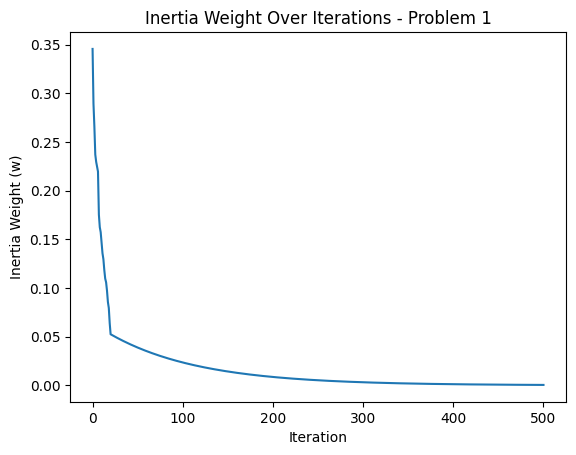

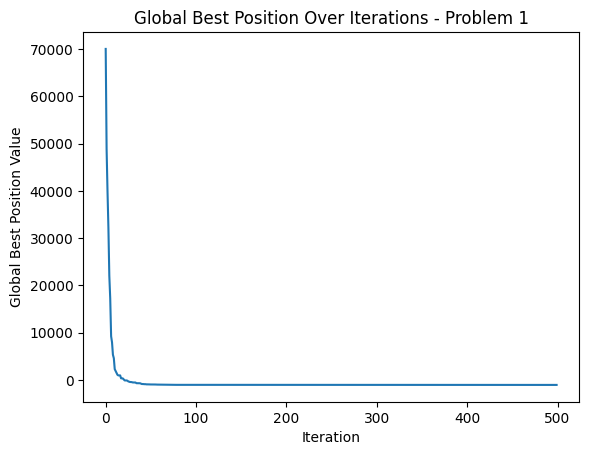




Problem 2 Best Cost: [-701.37774636 -701.40626675 -701.43104245 -701.44267138 -701.46440785
 -701.49783394 -701.53174518 -701.55086131 -701.57353425 -701.57353425
 -701.62001175 -701.63500467 -701.67617199 -701.67751571 -701.67751571
 -701.69795637 -701.70108006 -701.70473239 -701.70734701 -701.70734701
 -701.73767196 -701.73767196 -701.74379976 -701.74379976 -701.74379976
 -701.75260207 -701.75792172 -701.75792172 -701.77292664 -701.79088535
 -701.79088535 -701.80084028 -701.81392886 -701.81392886 -701.81392886
 -701.81392886 -701.81643449 -701.84201841 -701.84201841 -701.84391711
 -701.8442308  -701.86313291 -701.8717247  -701.8717247  -701.8717247
 -701.88641135 -701.88641135 -701.88641135 -701.88641135 -701.89111125
 -701.89111125 -701.91805305 -701.92311028 -701.92311028 -701.93007119
 -701.93007119 -701.93007119 -701.93007119 -701.93007119 -701.94923645
 -701.94923645 -701.94923645 -701.95154526 -701.95154526 -701.96340682
 -701.97097707 -701.97401431 -701.98423231 -701.984232

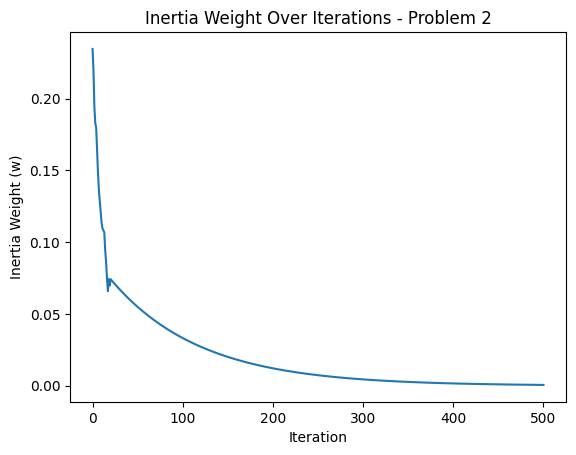

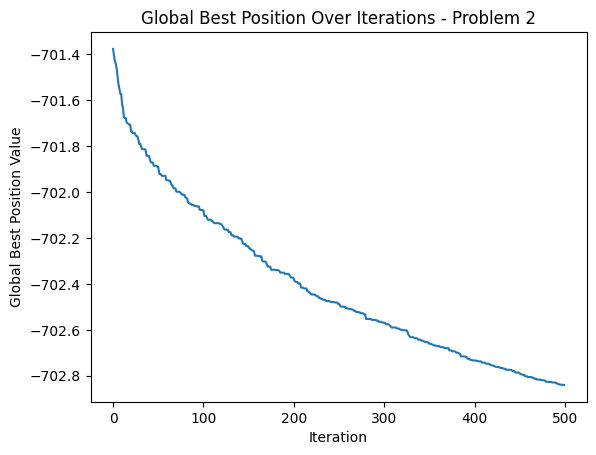




Problem 3 Best Cost: [ 3.58758801e+10  2.36060818e+10  2.01072616e+10  1.39850236e+10
  1.12463641e+10  8.83096740e+09  7.06490044e+09  4.84013117e+09
  4.65675028e+09  3.95955493e+09  3.00958396e+09  2.09337520e+09
  2.00335646e+09  1.32785435e+09  9.75189636e+08  9.75189636e+08
  7.06962691e+08  7.06962691e+08  6.83147946e+08  6.83147946e+08
  6.83147946e+08  6.83147946e+08  6.83147946e+08  3.85712094e+08
  3.85712094e+08  2.94065006e+08  2.29610911e+08  2.26598161e+08
  2.26598161e+08  2.26598161e+08  2.20369735e+08  1.97596886e+08
  1.97596886e+08  1.52902815e+08  1.52902815e+08  1.52509337e+08
  1.28051251e+08  1.28051251e+08  9.89774257e+07  8.86840413e+07
  7.86504792e+07  6.22110392e+07  6.22110392e+07  6.19983984e+07
  6.19983984e+07  6.19983984e+07  5.02646501e+07  4.84292788e+07
  3.08585592e+07  3.08585592e+07  2.92144192e+07  2.92144192e+07
  2.53894048e+07  2.53894048e+07  1.92305909e+07  1.92305909e+07
  1.44849691e+07  1.29844892e+07  1.29844892e+07  1.15739087e+07
 

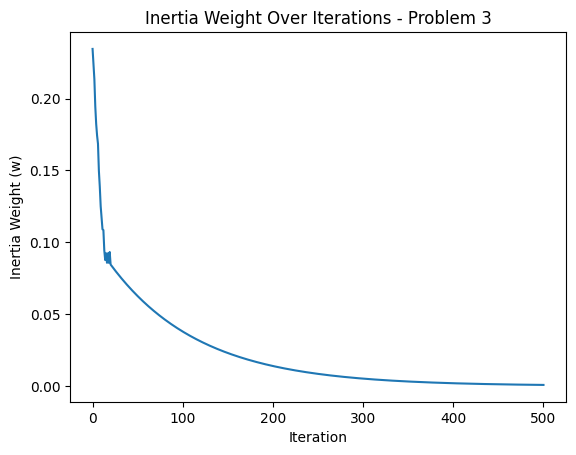

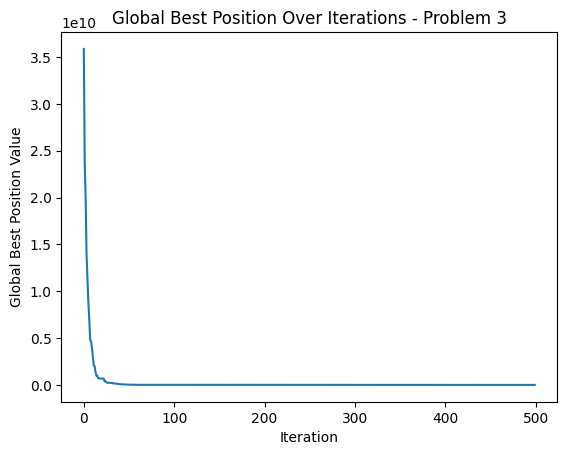




Problem 4 Best Cost: [ 3.54274778e+05  2.30053854e+05  2.07960125e+05  1.66747613e+05
  1.35379754e+05  9.66132429e+04  6.94028984e+04  4.00936810e+04
  4.00936810e+04  4.00936810e+04  3.48460511e+04  2.56763605e+04
  2.17790088e+04  1.56662220e+04  1.24362950e+04  1.24362950e+04
  1.24362950e+04  1.18398695e+04  9.19876262e+03  7.85096488e+03
  4.60653848e+03  4.60653848e+03  4.60653848e+03  4.37625805e+03
  4.09505031e+03  2.49475006e+03  2.42322203e+03  2.40873469e+03
  2.30357122e+03  1.96075344e+03  1.47792749e+03  1.28526429e+03
  9.54167350e+02  9.54167350e+02  9.54167350e+02  9.54167350e+02
  9.54167350e+02  9.03775084e+02  8.18046932e+02  8.18046932e+02
  8.18046932e+02  6.15392668e+02  6.15392668e+02  6.03872683e+02
  6.03872683e+02  5.37091530e+02  4.53974760e+02  3.89790804e+02
  3.89790804e+02  3.89790804e+02  3.65155701e+02  2.75518063e+02
  2.75518063e+02  2.75518063e+02  2.72125686e+02  1.18982963e+02
  1.18982963e+02  1.03345896e+02  9.41463397e+01  9.41463397e+01
 

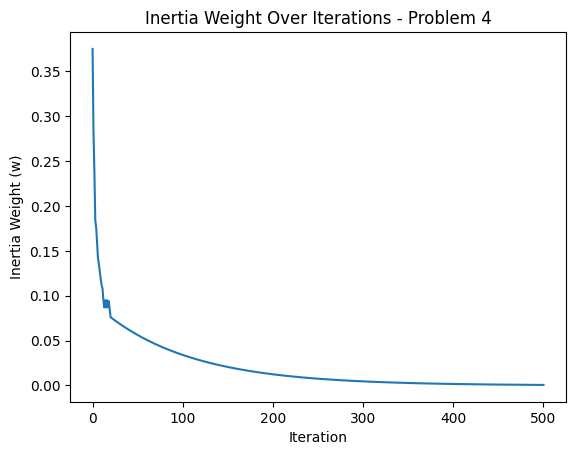

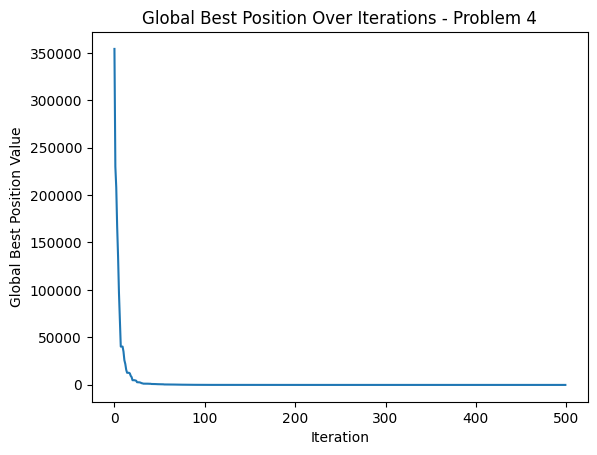




Problem 5 Best Cost: [-334.13672796 -334.18883789 -334.24424472 -334.28330687 -334.33344742
 -334.40032007 -334.41491721 -334.47237934 -334.50328407 -334.5433075
 -334.59857774 -334.62393929 -334.67226097 -334.69565902 -334.72579704
 -334.72579704 -334.72579704 -334.76415029 -334.78741373 -334.78741373
 -334.78908489 -334.80163216 -334.80713173 -334.81747321 -334.82134224
 -334.82680886 -334.84859781 -334.85249351 -334.85678168 -334.85678168
 -334.85702691 -334.8603473  -334.87758275 -334.93875286 -334.93875286
 -334.93875286 -334.93875286 -334.94866908 -334.95333492 -334.95333492
 -334.95333492 -334.96318797 -334.96318797 -334.96318797 -334.99191193
 -334.99200328 -334.99573281 -334.99573281 -334.99573281 -335.0046221
 -335.02683163 -335.02683163 -335.03506222 -335.03899896 -335.03967215
 -335.04039049 -335.05345126 -335.05345126 -335.05345126 -335.06462142
 -335.06462142 -335.06462142 -335.08528563 -335.08528563 -335.08807166
 -335.09147908 -335.09147908 -335.10296859 -335.1044680

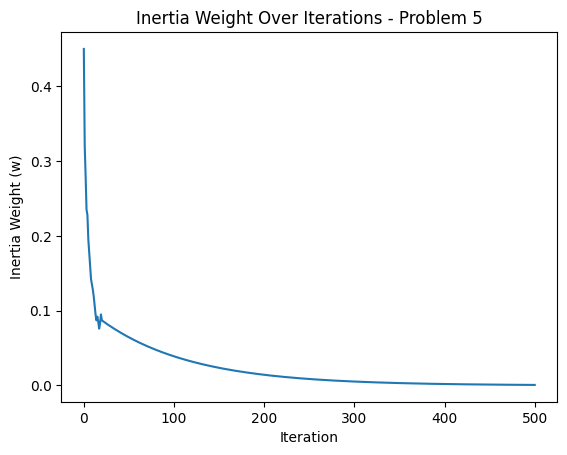

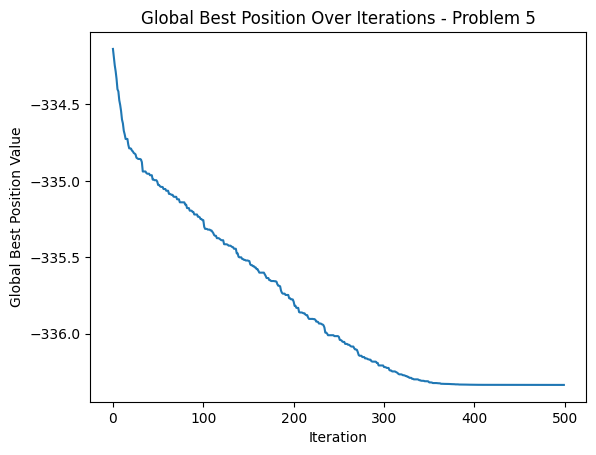




Problem 6 Best Cost: [-183.5113395  -183.5774105  -183.63668753 -183.66579423 -183.70356209
 -183.77367894 -183.77800914 -183.83194725 -183.91824655 -183.93641825
 -183.97804293 -183.98187071 -184.00252124 -184.00682768 -184.00682768
 -184.02589631 -184.0264596  -184.03841007 -184.05109519 -184.0782678
 -184.08695367 -184.09100777 -184.09100777 -184.11086776 -184.11835431
 -184.11835431 -184.11835431 -184.12386814 -184.13563482 -184.18808053
 -184.18808053 -184.19990455 -184.20795034 -184.24314837 -184.24314837
 -184.24380047 -184.24380047 -184.24380047 -184.27808312 -184.27808312
 -184.30777172 -184.32844018 -184.32844018 -184.32844018 -184.36140456
 -184.36140456 -184.38454922 -184.38454922 -184.38454922 -184.40756822
 -184.41173625 -184.41173625 -184.41173625 -184.41173625 -184.41173625
 -184.41173625 -184.41624613 -184.42720775 -184.42720775 -184.42720775
 -184.44254772 -184.45363171 -184.4846508  -184.4862848  -184.4862848
 -184.4862848  -184.51081433 -184.51081433 -184.5108143

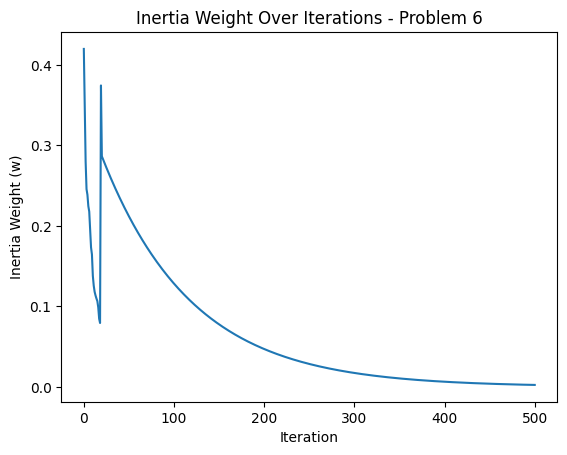

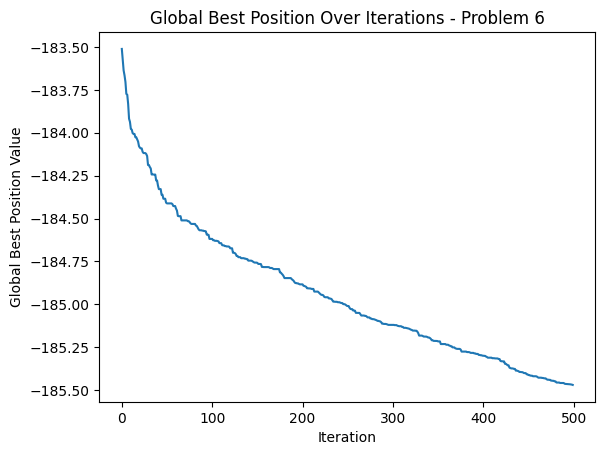




Problem 7 Best Cost: [58956.93370212 57856.77041571 41748.27023609 41748.27023609
 34079.90222929 24504.00425691 19747.00608671 18930.24982762
 14707.99881912 12867.00243468 10361.87277739 10361.87277739
  8960.00908295  8960.00908295  8960.00908295  8892.2527709
  8242.70616157  7103.7136583   7103.7136583   7103.7136583
  7103.7136583   7103.7136583   7103.7136583   7103.7136583
  7103.7136583   7103.7136583   7103.7136583   7084.4786787
  6865.83511384  6721.73332801  6721.73332801  6042.63223552
  4979.54749748  4979.54749748  4979.54749748  4979.54749748
  4967.29472865  4967.29472865  4967.29472865  4947.29634836
  4780.53621692  4600.20525737  4443.04126557  4443.04126557
  4363.01978055  4363.01978055  4363.01978055  4363.01978055
  4356.98568074  4258.77424052  4258.77424052  4258.77424052
  4258.77424052  4258.77424052  4258.77424052  4199.64872037
  4199.64872037  4196.74447997  4163.8209972   4163.8209972
  4163.8209972   4163.8209972   4125.92999804  4125.92999804
  411

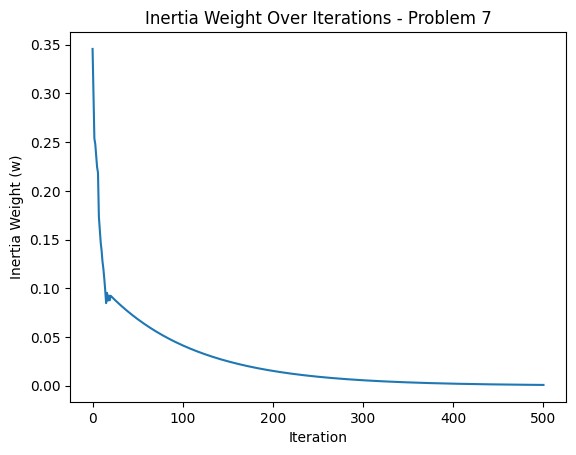

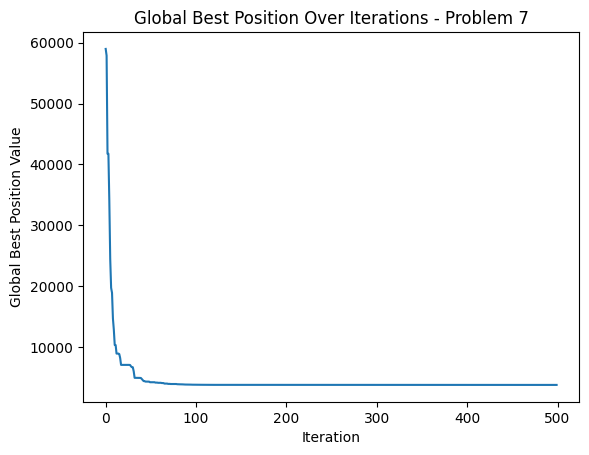




Problem 8 Best Cost: [68558.25633089 60123.57325462 44403.69915064 35228.34638647
 31749.08361704 31749.08361704 26524.65325965 26524.65325965
 26524.65325965 26524.65325965 26524.65325965 26336.22721301
 26336.22721301 26336.22721301 26336.22721301 26336.22721301
 26336.22721301 26336.22721301 26336.22721301 26299.25531362
 24211.32064406 24211.32064406 24211.32064406 24211.32064406
 24211.32064406 24211.32064406 24211.32064406 24211.32064406
 23290.23366045 22281.7574599  18884.65899101 18884.65899101
 18884.65899101 18884.65899101 18884.65899101 18884.65899101
 18884.65899101 18884.65899101 18884.65899101 18884.65899101
 17087.63308536 17087.63308536 17087.63308536 17087.63308536
 16032.58813953 16032.58813953 16032.58813953 16032.58813953
 16032.58813953 15336.16164903 15336.16164903 12500.60207294
 12153.19357588 12153.19357588 12153.19357588 12153.19357588
 12153.19357588 12153.19357588 12153.19357588 11820.16731046
 11596.55142967 11596.55142967 11596.55142967 11491.96919304


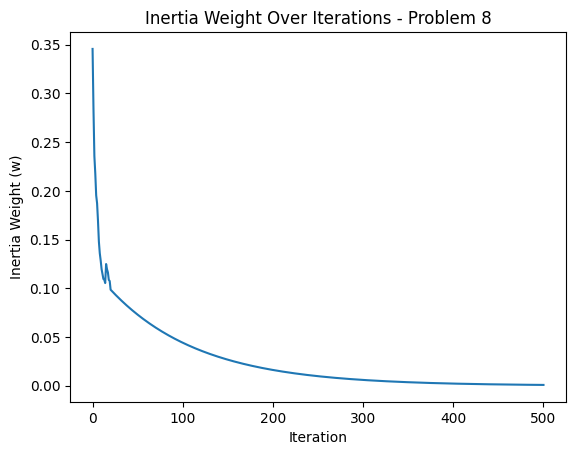

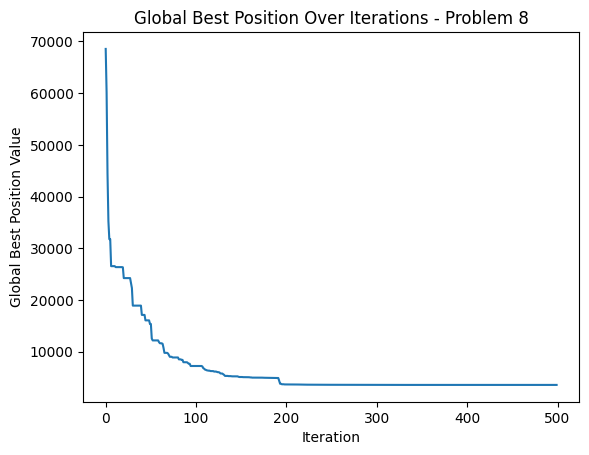




Problem 9 Best Cost: [145773.29320822  99349.14462817  99349.14462817  99349.14462817
  99349.14462817  99349.14462817  99349.14462817  99349.14462817
  99349.14462817  33850.67320526  33850.67320526  28348.28644071
  28348.28644071  28348.28644071  28348.28644071  28348.28644071
  28348.28644071  28348.28644071  28348.28644071  28348.28644071
  28348.28644071  28348.28644071  23858.38307286  23858.38307286
  19812.30930964  19812.30930964  12822.90427031  12797.21088905
  12797.21088905  12797.21088905  12797.21088905  12797.21088905
  12797.21088905  12797.21088905  12797.21088905  12797.21088905
  12797.21088905  12797.21088905  12797.21088905  12797.21088905
  12797.21088905   9891.79780094   9891.79780094   9891.79780094
   9891.79780094   9891.79780094   9891.79780094   9891.79780094
   9891.79780094   6225.15125763   6225.15125763   5145.46598657
   5145.46598657   4470.25921868   4470.25921868   4470.25921868
   4470.25921868   2703.44612035   2703.44612035   2703.44612035
 

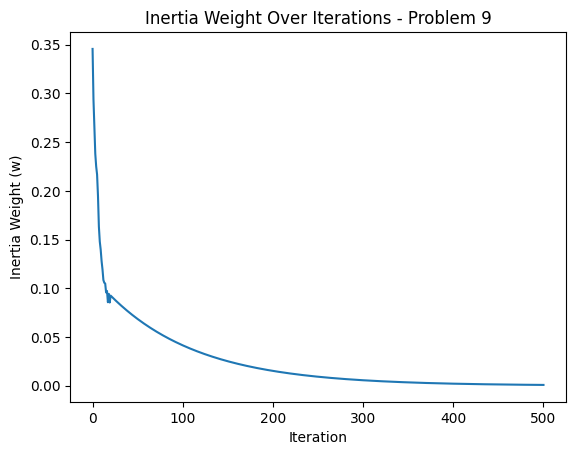

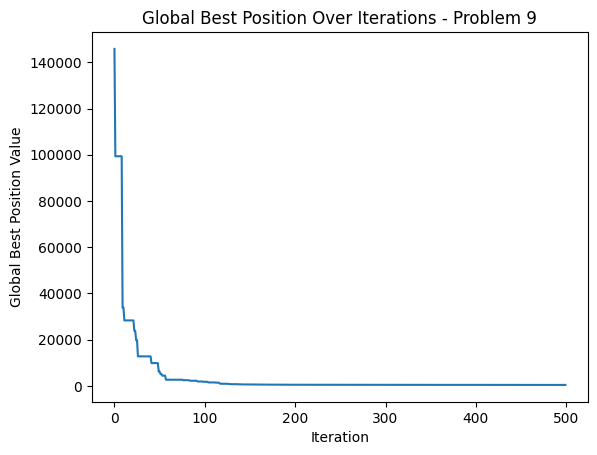




Problem 10 Best Cost: [62313.50779297 56613.58077832 39832.6680435  37622.98908043
 37622.98908043 20158.90859731 20158.90859731 20158.90859731
 20158.90859731 15715.99327913 15715.99327913 14607.90400637
 13017.68094996 13017.68094996 11976.50326941 11976.50326941
  9810.41320608  9810.41320608  9810.41320608  9810.41320608
  8870.58279414  8195.39841423  6643.11479463  6643.11479463
  5636.88829116  5636.88829116  5636.88829116  5636.88829116
  5636.88829116  5636.88829116  5636.88829116  5636.88829116
  5636.88829116  5636.88829116  5199.54534051  5108.91774678
  5108.91774678  5108.91774678  5108.91774678  5108.91774678
  5108.91774678  5108.91774678  5108.91774678  5108.91774678
  5108.91774678  4962.1044187   4962.1044187   4664.78377203
  4257.70183371  4190.12624995  3938.00922729  3938.00922729
  3850.06867028  3850.06867028  3850.06867028  3850.06867028
  3850.06867028  3850.06867028  3719.61620068  3619.77223681
  3619.77223681  3619.77223681  3619.77223681  3577.22617474

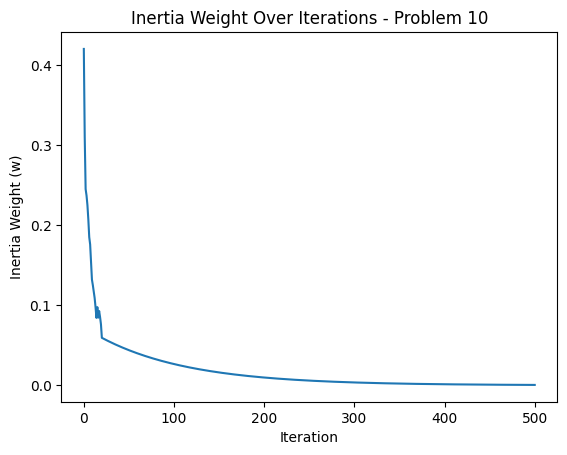

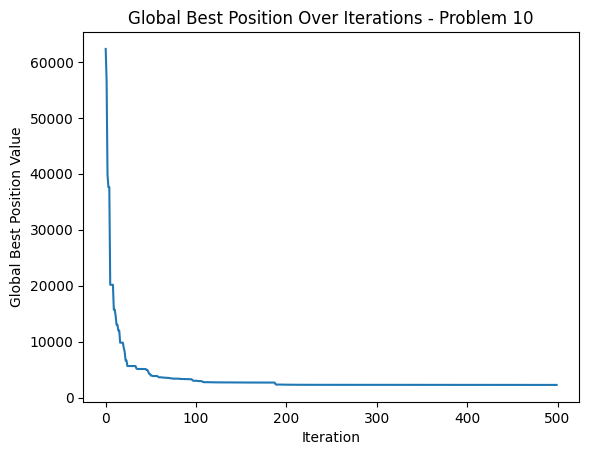




Problem 11 Best Cost: [80547.64505174 51452.87442948 36994.64666461 32364.74841016
 31804.37816307 31804.37816307 31804.37816307 31804.37816307
 31804.37816307 31804.37816307 31804.37816307 30416.67294178
 30416.67294178 30416.67294178 30071.43249321 27277.35265701
 27277.35265701 27277.35265701 27277.35265701 27277.35265701
 26702.6059219  20050.72360631 20050.72360631 20050.72360631
 20050.72360631 20050.72360631 20050.72360631 20050.72360631
 20050.72360631 20050.72360631 20050.72360631 20050.72360631
 20050.72360631 19373.85279892 17370.71572022 17370.71572022
 17370.71572022 17370.71572022 17370.71572022 17370.71572022
 17370.71572022 17370.71572022 17370.71572022 17370.71572022
 17370.71572022 17370.71572022 17370.71572022 17370.71572022
 17370.71572022 16733.43390552 16733.43390552 16733.43390552
 16733.43390552 16489.77935765 16489.77935765 16489.77935765
 16378.39047396 16378.39047396 16378.39047396 16378.39047396
 16011.02813699 16011.02813699 16011.02813699 16011.02813699

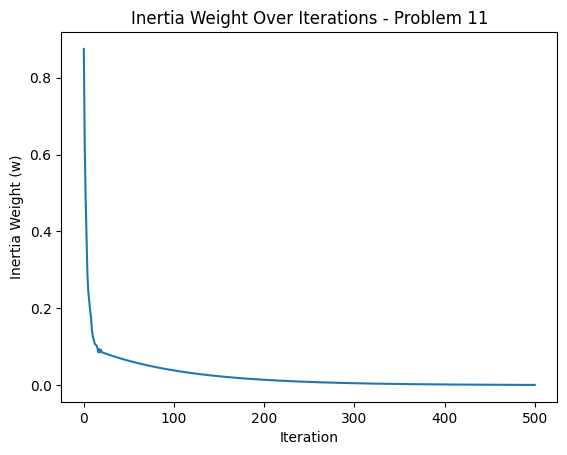

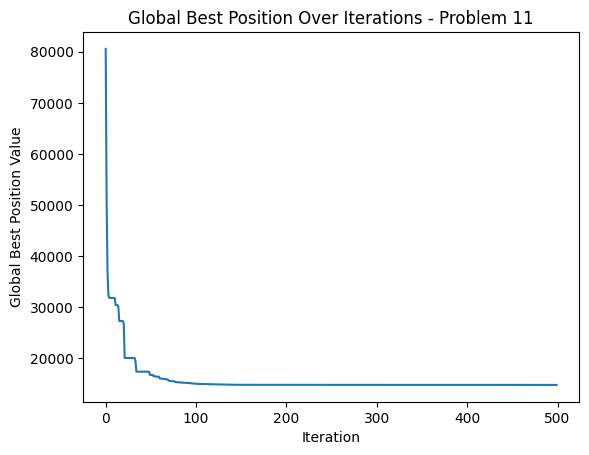




Problem 12 Best Cost: [61318.37744463 44859.13633923 32835.25457346 26984.73537817
 23916.29373163 23916.29373163 22190.69070422 22190.69070422
 22190.69070422 18023.14343404 11488.46328703 11488.46328703
 11488.46328703 11488.46328703 11488.46328703 11488.46328703
 11488.46328703  8754.25361756  8754.25361756  7640.62868137
  7161.7933247   7161.7933247   7161.7933247   7161.7933247
  7161.7933247   7006.21020914  6851.75014131  5942.62118747
  5942.62118747  5942.62118747  5942.62118747  5942.62118747
  5942.62118747  5942.62118747  5942.62118747  5942.62118747
  5942.62118747  5942.62118747  5561.30310468  5561.30310468
  5561.30310468  5561.30310468  5561.30310468  5561.30310468
  5561.30310468  5561.30310468  5561.30310468  5561.30310468
  5561.30310468  5561.30310468  5561.30310468  5561.30310468
  5561.30310468  5495.86408085  4989.83378852  4886.09554675
  4886.09554675  4508.71693483  4508.71693483  4366.2639675
  4366.2639675   4366.2639675   4366.2639675   4027.01116563
 

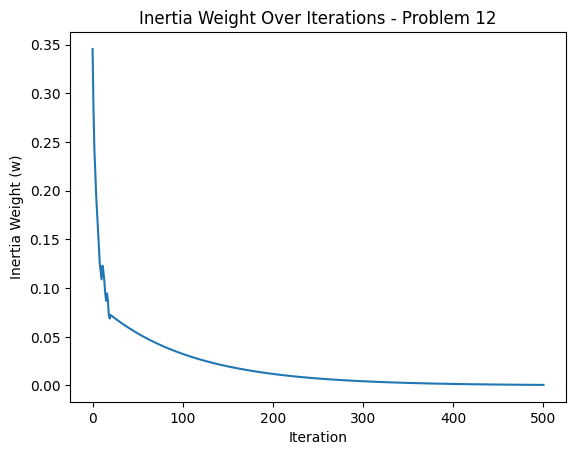

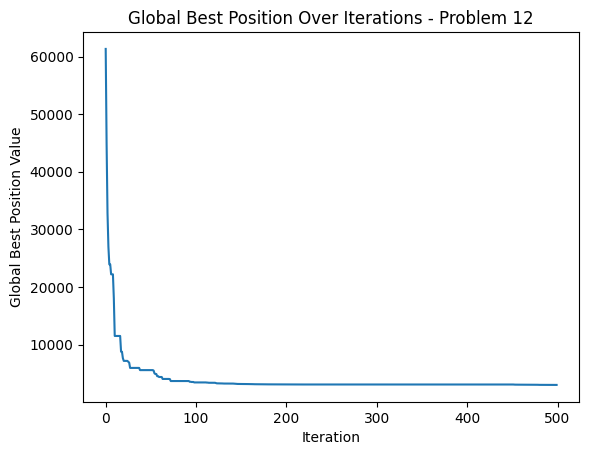




Problem 13 Best Cost: [229440.02370675  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  83022.28424543
  83022.28424543  83022.28424543  83022.28424543  82171.13129615
  82171.13129615  82171.13129615  70508.79517505  70508.79517505
  70508.79517505  70508.79517505  70508.79517505  70508.79517505
  70508.79517505  70508.79517505  44552.32194989  44552.32194989


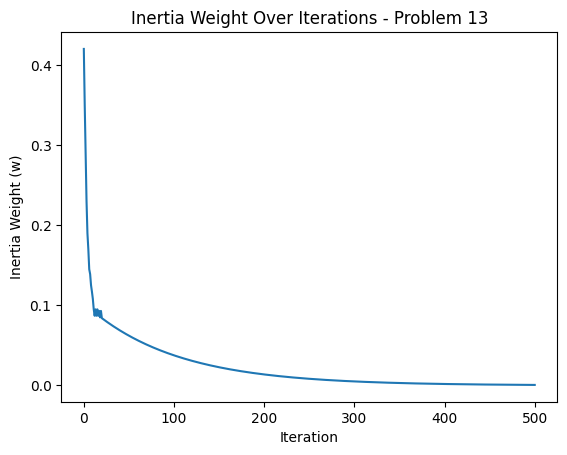

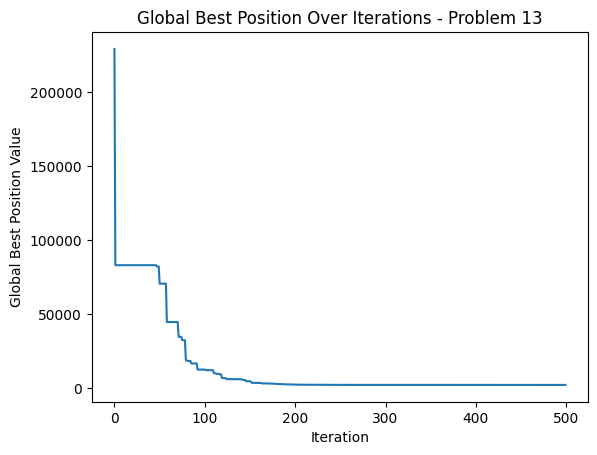




Problem 14 Best Cost: [39484.95142214 32961.54376426 26311.28864448 25785.52546644
 23109.20767306 23109.20767306 21188.69777457 21188.69777457
 21188.69777457 21188.69777457 21188.69777457 21188.69777457
 21188.69777457 21188.69777457 21188.69777457 19837.05520406
 19170.21850251 19170.21850251 19170.21850251 18728.1247203
 16416.36475486 16129.79327356 15988.18607905 15988.18607905
 15988.18607905 14053.14857607 12780.51244051 12780.51244051
 12287.37190243 12287.37190243 12287.37190243 12287.37190243
 11281.97930407 11281.97930407 11281.97930407 11281.97930407
 11281.97930407 11281.97930407 11281.97930407 11281.97930407
 11281.97930407 11281.97930407 11138.39643541 10720.39824728
 10235.38326821 10235.38326821 10235.38326821 10142.56264951
 10142.56264951  9388.24030921  9388.24030921  9388.24030921
  9388.24030921  9388.24030921  9388.24030921  9388.24030921
  9388.24030921  9388.24030921  9388.24030921  9388.24030921
  9388.24030921  9388.24030921  9388.24030921  9388.24030921


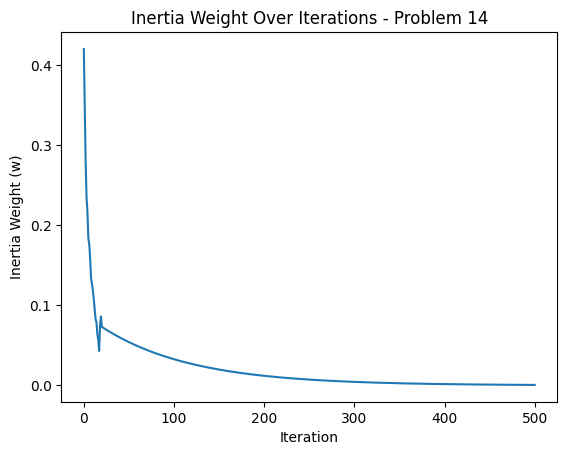

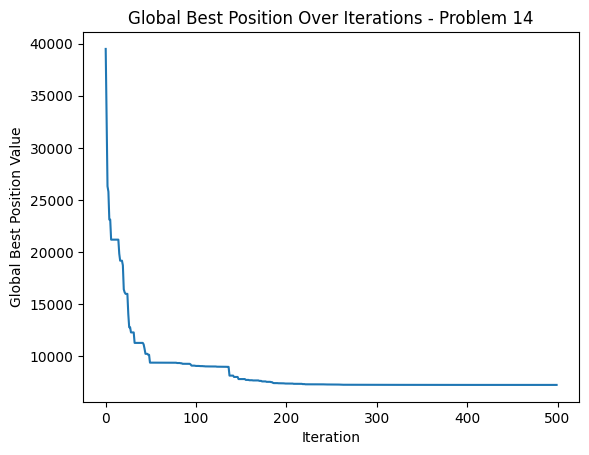




Problem 15 Best Cost: [-224.81357715 -224.81357715 -224.98875066 -224.98875066 -224.99080185
 -224.99080185 -226.1771566  -226.1771566  -226.1771566  -226.1771566
 -226.1771566  -226.29662857 -226.29662857 -226.62556718 -226.62556718
 -226.68415537 -226.8058193  -226.8058193  -226.8058193  -227.01800382
 -227.01800382 -227.01800382 -227.01800382 -227.24676245 -227.24676245
 -227.24676245 -227.24676245 -227.24676245 -227.39814575 -227.39814575
 -227.39814575 -227.46944734 -227.46944734 -227.46944734 -227.46944734
 -227.46944734 -227.46944734 -227.50858916 -227.57913113 -227.57913113
 -227.57913113 -227.57913113 -227.57913113 -227.57913113 -227.57913113
 -227.57913113 -227.727869   -227.727869   -227.7382573  -227.78550632
 -227.78550632 -227.79704581 -227.79704581 -227.79704581 -227.79704581
 -227.86042146 -227.86042146 -227.86042146 -227.86042146 -227.86042146
 -227.86042146 -227.86042146 -227.86042146 -227.86042146 -227.86042146
 -227.86042146 -227.89279357 -227.89279357 -227.89279

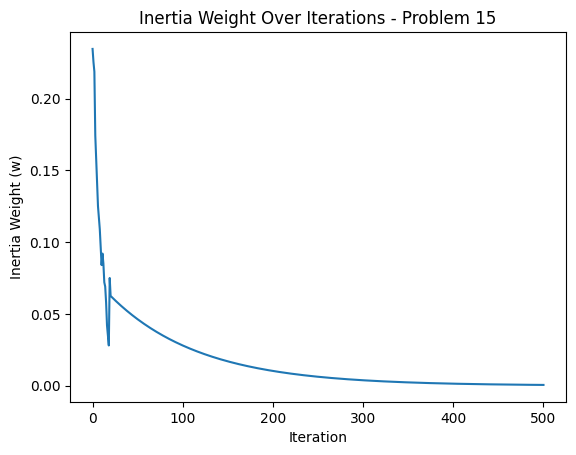

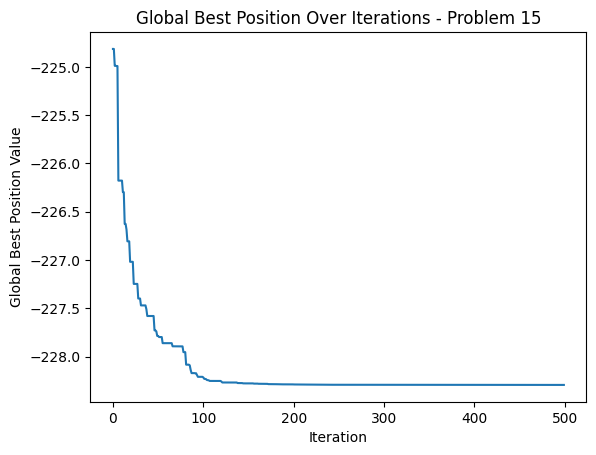




Problem 16 Best Cost: [ 6.25841614e+04  4.26287699e+04  2.97595036e+04  2.03992331e+04
  1.48992505e+04  6.94240983e+03 -2.04296020e+01 -2.04296020e+01
 -2.04296020e+01 -2.64555465e+01 -7.93454082e+02 -1.22237641e+03
 -1.97742395e+03 -1.97742395e+03 -2.38844824e+03 -2.76137835e+03
 -2.82335962e+03 -3.31478686e+03 -3.49245674e+03 -3.49245674e+03
 -3.60032680e+03 -3.74427144e+03 -3.75082040e+03 -3.80003793e+03
 -3.80003793e+03 -3.80003793e+03 -3.82778539e+03 -3.82778539e+03
 -3.82778539e+03 -3.82778539e+03 -3.85123705e+03 -3.86438123e+03
 -3.86438123e+03 -3.88787900e+03 -3.91800307e+03 -3.92044123e+03
 -4.01471718e+03 -4.01471718e+03 -4.01471718e+03 -4.01471718e+03
 -4.01471718e+03 -4.07647344e+03 -4.09998440e+03 -4.11773447e+03
 -4.13010768e+03 -4.13010768e+03 -4.15900452e+03 -4.15900452e+03
 -4.16910109e+03 -4.17805517e+03 -4.17805517e+03 -4.17805517e+03
 -4.17805517e+03 -4.18622011e+03 -4.18622011e+03 -4.19422507e+03
 -4.21613417e+03 -4.21949934e+03 -4.22405027e+03 -4.23924849e+03


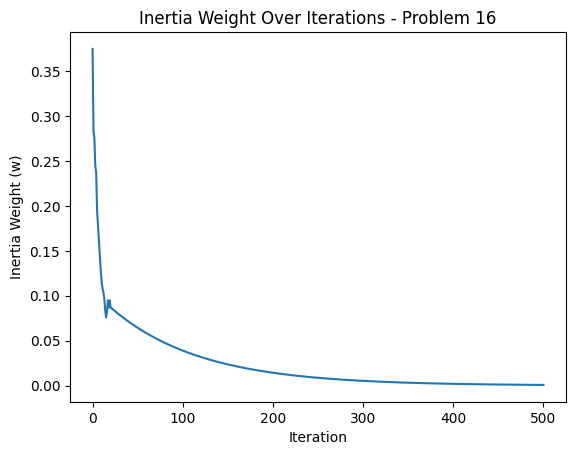

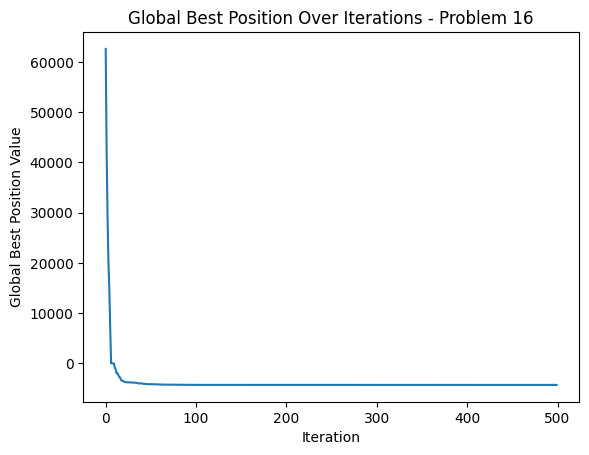




Problem 17 Best Cost: [ 3.47690632e+06  2.62930328e+06  2.08326174e+06  1.77576419e+06
  1.23933874e+06  1.16358396e+06  6.66075659e+05  5.28626261e+05
  5.25093663e+05  5.25093663e+05  4.14752107e+05  2.83571921e+05
  2.69913942e+05  2.05480206e+05  1.97827585e+05  1.60796732e+05
  1.57909688e+05  1.25519837e+05  1.01853402e+05  9.94494793e+04
  9.80434980e+04  6.56856570e+04  6.36894377e+04  6.36894377e+04
  5.95353239e+04  4.62360634e+04  4.62360634e+04  4.42648962e+04
  4.08493681e+04  4.08493681e+04  4.04172075e+04  3.48132453e+04
  3.48132453e+04  3.11704367e+04  2.72389318e+04  2.57968242e+04
  2.50310269e+04  2.50310269e+04  2.13943588e+04  2.13943588e+04
  2.00580146e+04  2.00580146e+04  2.00580146e+04  2.00580146e+04
  1.76889250e+04  1.72843302e+04  1.40423700e+04  1.40423700e+04
  1.40423700e+04  1.33718439e+04  1.31336515e+04  1.21407817e+04
  1.03444238e+04  9.78867787e+03  8.63215823e+03  8.42366087e+03
  7.89060300e+03  7.89060300e+03  7.82133398e+03  6.99287344e+03


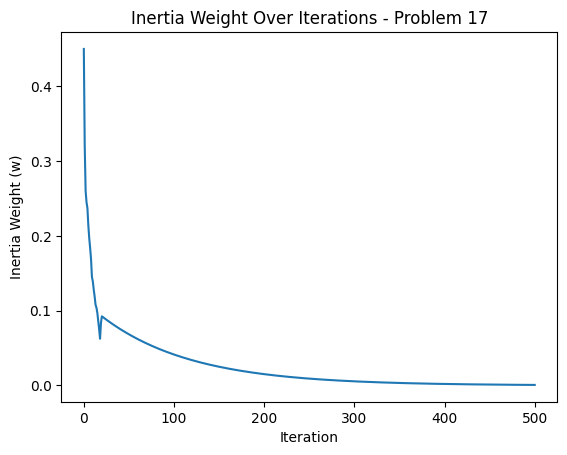

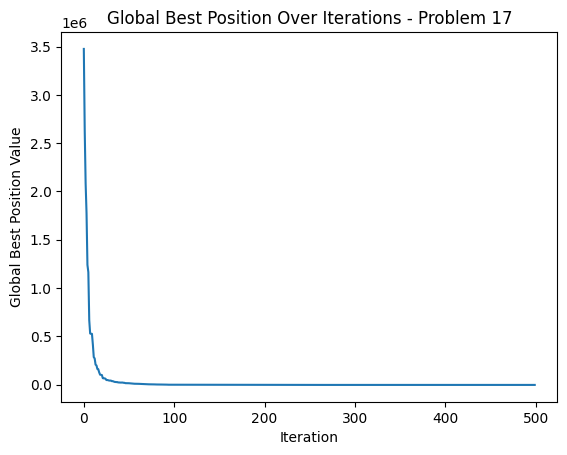




Problem 18 Best Cost: [44377.65535788 44377.65535788 44377.65535788 33341.41606145
 29667.61108743 24116.91777015 22498.417628   16231.66154465
 14066.64333712 14066.64333712 11195.41154627  9172.81663156
  9172.81663156  9172.81663156  9172.81663156  8585.56309531
  8464.59128023  8464.59128023  8464.59128023  8464.59128023
  8464.59128023  7524.13350948  7524.13350948  7524.13350948
  6342.91952196  6342.91952196  6342.91952196  6342.91952196
  6342.91952196  6342.91952196  6342.91952196  6277.94678787
  6277.94678787  6277.94678787  6277.94678787  5404.59182024
  5404.59182024  5404.59182024  4501.13423352  4501.13423352
  4501.13423352  4373.80391709  4373.80391709  4373.80391709
  4373.80391709  4373.80391709  4373.80391709  4373.80391709
  4373.80391709  4373.80391709  4373.80391709  4373.80391709
  4373.80391709  4373.80391709  3496.10150326  3496.10150326
  3419.78047553  3419.78047553  3419.78047553  3419.78047553
  3419.78047553  3419.78047553  3419.78047553  3419.78047553

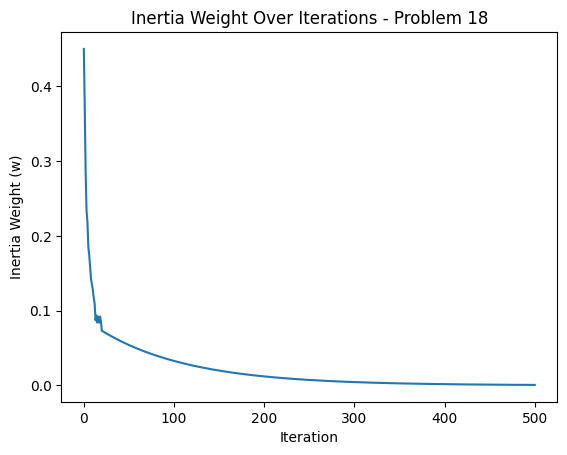

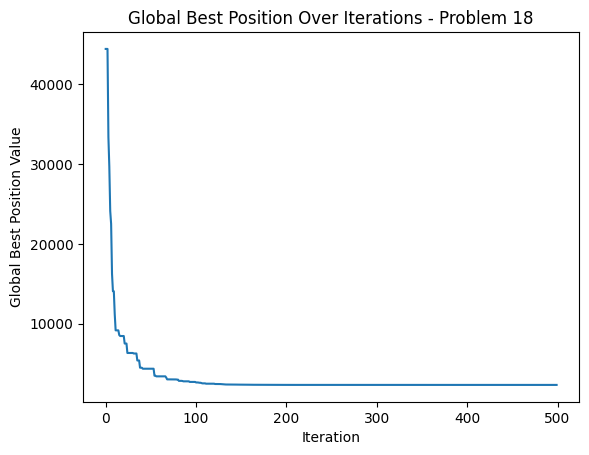




Problem 19 Best Cost: [65201.53522613 46471.54553882 46471.54553882 36699.36934246
 34922.78279099 34922.78279099 28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  28243.6957359  28243.6957359
 28243.6957359  28243.6957359  25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374.87879655 25374.87879655 25374.87879655 25374.87879655
 25374

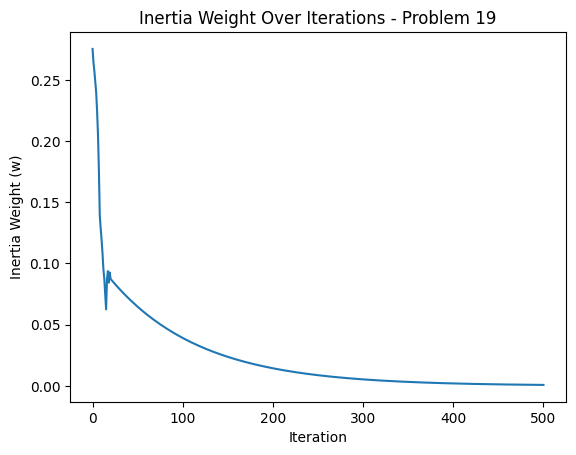

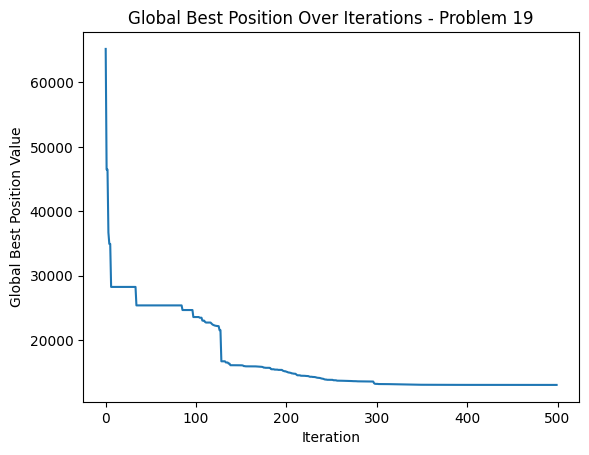




Problem 20 Best Cost: [-83.17506342 -84.3022277  -84.3022277  -85.47806274 -85.47806274
 -85.65945296 -86.52273023 -86.52273023 -86.52273023 -86.80924008
 -87.0589104  -87.0589104  -87.0589104  -87.0589104  -87.52287244
 -87.52287244 -87.52287244 -87.52287244 -87.52287244 -88.00077821
 -88.00077821 -88.00077821 -88.00077821 -88.00077821 -88.00077821
 -88.00077821 -88.00077821 -88.00077821 -88.00077821 -88.00077821
 -88.00077821 -88.00077821 -88.07403089 -88.07403089 -88.07403089
 -88.07403089 -88.07403089 -88.08244108 -88.45669837 -88.45669837
 -88.45669837 -88.45669837 -88.45669837 -88.45669837 -88.45669837
 -88.45669837 -88.45669837 -88.45669837 -88.45669837 -88.45669837
 -88.45669837 -88.45669837 -88.45669837 -88.45669837 -88.45669837
 -88.45669837 -88.45669837 -88.45669837 -88.45669837 -88.45669837
 -88.45669837 -88.45669837 -88.45669837 -88.46032634 -88.46032634
 -88.55228144 -88.55228144 -88.74380763 -88.74380763 -88.76193337
 -88.76193337 -88.96776938 -89.1330713  -89.1330713

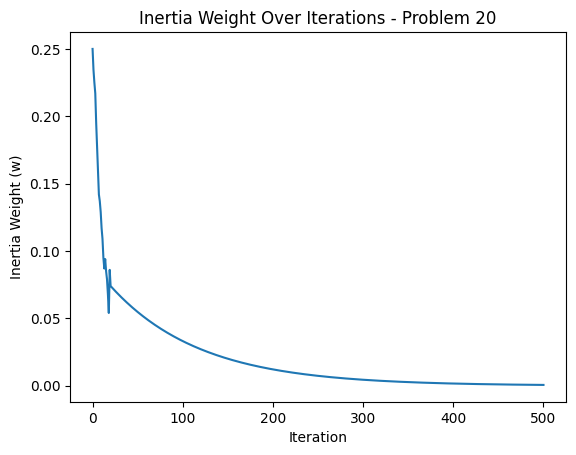

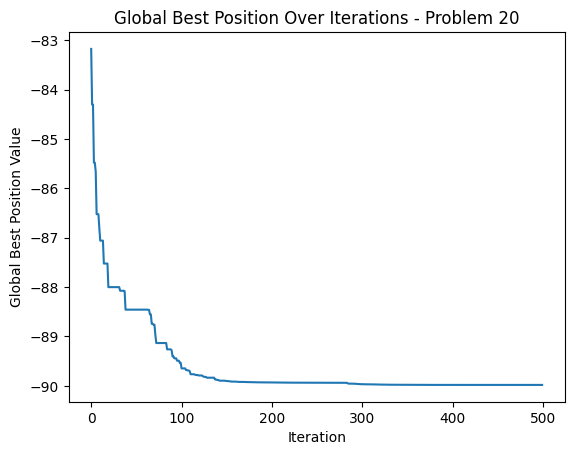




Problem 21 Best Cost: [170.05308351 101.38738627  49.56815589  28.85898929  14.12198369
   4.82833014   2.82436859   1.69566003  -5.60663659  -5.60663659
  -5.60663659  -5.60663659  -5.60663659 -16.58840503 -16.58840503
 -20.03506834 -20.03506834 -20.03506834 -20.03506834 -22.5523898
 -22.5523898  -22.5523898  -22.5523898  -22.5523898  -22.5523898
 -22.5523898  -25.2420325  -25.2420325  -25.49163085 -26.05618653
 -28.68767295 -28.68767295 -28.68767295 -28.68767295 -29.2475191
 -29.2475191  -29.2475191  -29.81730192 -29.81730192 -30.21727456
 -30.21727456 -30.4573673  -31.02156862 -31.02156862 -31.2638048
 -31.27882331 -31.27882331 -31.39311836 -31.39311836 -31.73581422
 -33.33359915 -33.88336117 -33.88336117 -33.88336117 -33.88336117
 -33.88336117 -35.13591044 -35.13591044 -35.94115377 -35.94115377
 -36.19369565 -36.19369565 -36.25038387 -36.25038387 -36.25038387
 -36.56021823 -37.10317806 -37.26035368 -37.5170603  -37.5170603
 -37.5170603  -37.57626979 -37.68509235 -37.88491924 -37

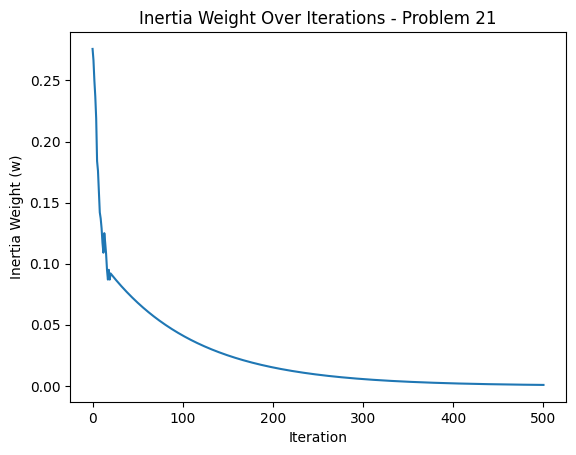

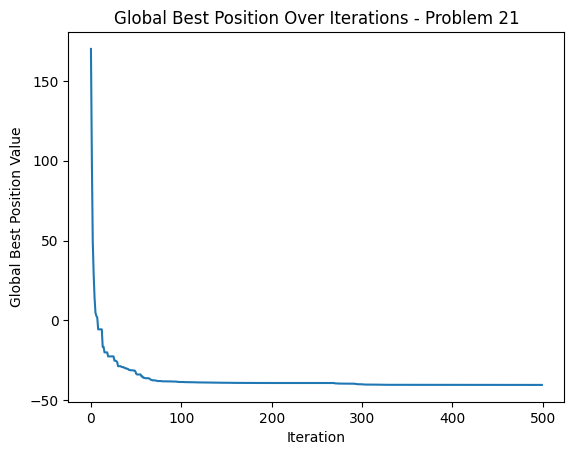




Problem 22 Best Cost: [242855.59291859 229363.99877561 225855.95741458 214273.27350901
 191694.66147131 191694.66147131 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 146464.11626333 146464.11626333 146464.11626333
 146464.11626333 145215.21386563 145215.21386563 142218.77614954
 142218.77614954 138383.4107841  133630.30106302 133630.30106302
 128582.64908285 128582.64908285 128582.64908285 127752.36993589
 127752.36993589 127752.36993589 125027.25366923 123755.20809272
 123755.20809272 123755.20809272 122798.63647375 119834.93928813
 119834.93928813 119834.93928813 119834.93928813 119834.93928813
 119834.93928813 119834.93928813 117141.27301968 117141.27301968


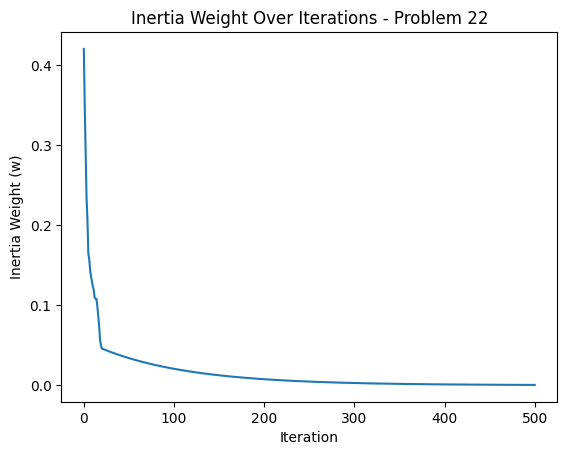

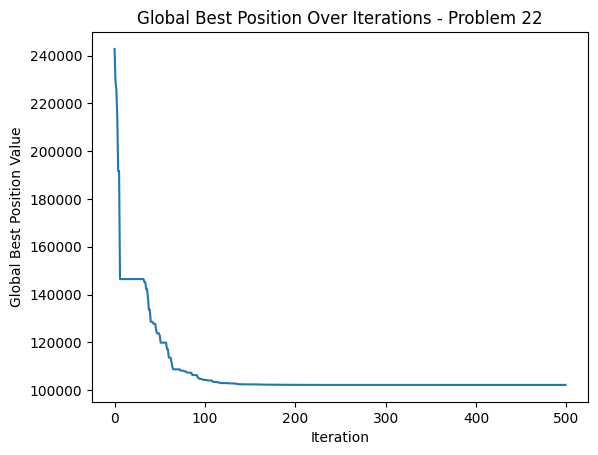




Problem 23 Best Cost: [-16.8062653  -21.03971806 -26.39342522 -31.54384779 -31.54384779
 -34.82343772 -34.82343772 -34.87226465 -37.21441081 -37.21441081
 -37.21441081 -37.21441081 -37.21441081 -37.21441081 -37.21441081
 -38.78195667 -38.78195667 -38.78195667 -38.78195667 -38.78195667
 -38.78195667 -38.78195667 -38.78195667 -43.56938506 -43.56938506
 -43.56938506 -43.56938506 -43.56938506 -43.56938506 -46.90840829
 -46.90840829 -46.90840829 -46.90840829 -46.90840829 -46.90840829
 -46.90840829 -46.90840829 -46.90840829 -46.90840829 -46.90840829
 -46.90840829 -46.90840829 -46.90840829 -46.90840829 -47.092726
 -47.092726   -47.93949431 -49.16975461 -49.16975461 -49.16975461
 -49.16975461 -49.16975461 -49.16975461 -49.16975461 -49.16975461
 -49.16975461 -50.13552722 -50.13552722 -50.84837749 -51.88405097
 -52.36548366 -52.36548366 -52.36548366 -52.36548366 -52.65960446
 -53.67598154 -53.67598154 -53.67598154 -53.67598154 -53.67598154
 -54.30107861 -54.30107861 -54.39050342 -55.09348558 

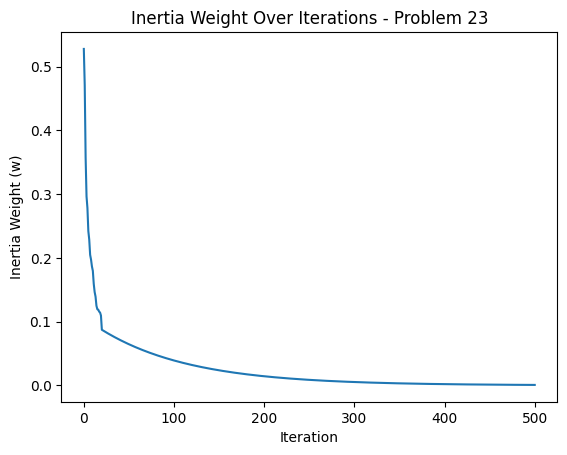

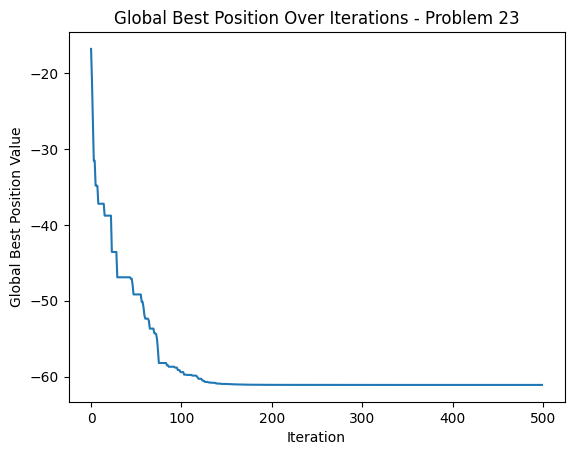




Problem 24 Best Cost: [106.34491944 106.34491944 106.34491944 106.34491944 103.5879523
  98.85330871  98.85330871  98.85330871  98.85330871  90.68358359
  90.68358359  89.31720895  81.11976761  79.833088    79.833088
  79.833088    79.833088    79.833088    75.42606202  75.42606202
  65.58942139  63.75343263  63.75343263  63.75343263  63.75343263
  63.75343263  63.75343263  63.75343263  63.75343263  63.59958353
  59.97735982  59.97735982  59.97735982  56.86582159  56.86582159
  56.86582159  56.86582159  56.86582159  51.18788103  50.59070463
  50.59070463  50.59070463  50.59070463  50.59070463  50.59070463
  50.59070463  47.35585169  47.35585169  47.35585169  47.23641704
  47.23641704  46.03814163  46.03814163  46.03814163  44.44867474
  44.44867474  44.44867474  44.44867474  34.41293419  34.41293419
  34.41293419  34.41293419  34.41293419  34.41293419  34.41293419
  34.41293419  34.41293419  34.41293419  34.41293419  34.41293419
  34.41293419  34.41293419  34.41293419  34.41293419  

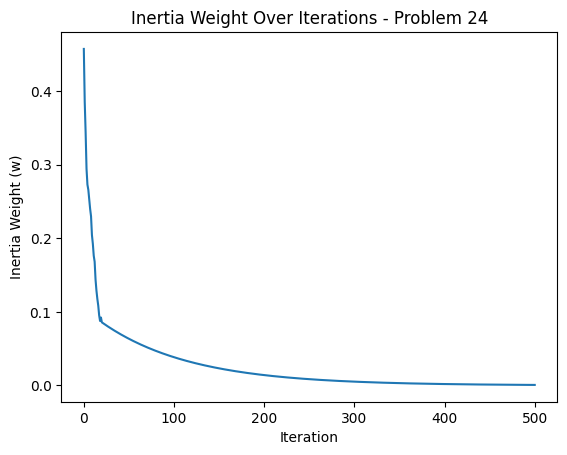

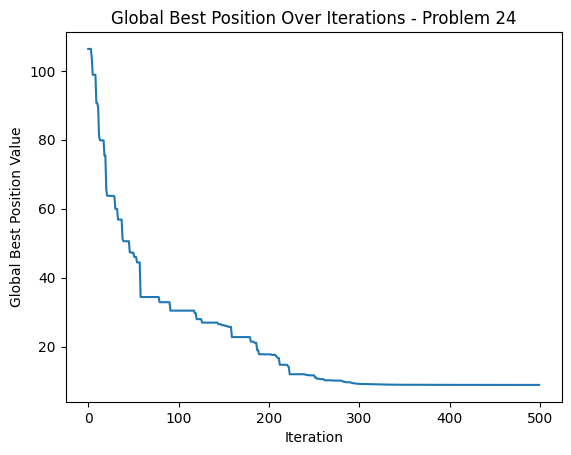

In [39]:
for prob in range(24):
    curr = prob + 1
    problem_results = results[curr]

    print("\n\n\nProblem", curr, "Best Cost:", problem_results['BestCost'])
    print("Problem", curr, "Best Position:", problem_results['BestPosition'])

    plt.plot(problem_results['w_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Inertia Weight (w)')
    plt.title(f'Inertia Weight Over Iterations - Problem {curr}')
    plt.show()

    plt.plot(problem_results['g_values'])
    plt.xlabel('Iteration')
    plt.ylabel('Global Best Position Value')
    plt.title(f'Global Best Position Over Iterations - Problem {curr}')
    plt.show()

In [40]:
print('nice')

nice


In [41]:
print('almost complete')

almost complete


In [42]:
print("Don't disconnect runtime")

Don't disconnect runtime


In [43]:
ok

NameError: name 'ok' is not defined